# Modelo lineal dinámico (Dynamic Linear Model)

In [2]:
## Ejemplo: instalación de astsadata usando pip:
#!pip install astsadata
#Importo astsadata
import warnings
with warnings.catch_warnings(action="ignore"):
    import astsadata as astsa

## Ajusto tamaño de figuras
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import pandas as pd

plt.rcParams['figure.figsize'] = [15,5]
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.constrained_layout.use'] = True

## Modelos en espacio de estados:

La idea de los modelos en espacio de estados es poder representar procesos que tienen una *dinámica interna*, es decir:

 * Poseen un *estado* $x_t$, que evolucione en el tiempo, y que en general no es observable.
 * Podemos medir uno o más valores $y_t$, denominados *observaciones*, y cuyo comportamiento depende del estado $x_t$ en que se encuentra el proceso.
 
### Problemas:

 * Dadas las observaciones $y_0,\ldots,y_n$, ¿como reconstruimos $x_0,\ldots,x_n$?
 * Dado un conjunto de observaciones $y_0,\ldots,y_n$, ¿cómo ajustamos un modelo a la evolución del estado $x$?
 * ¿Como podemos predecir estados/observaciones futuras?

### Diagrama:

![espacio_estados](../images/statespace.png "Estados y obsevaciones")


### Ejemplos de modelos:

 * Modelos con estados continuos y observaciones continuas (sistemas dinámicos de tiempo discreto con ruido)
     
     * Para ello se estudian herramientas matriciales, en particular el filtro de Kalman.
     * Se aplican en general cuando hay un modelo físico subyacente.
     * Un ejemplo de esto es el **Modelo lineal dinámico**.
     
 * Modelos con estados discretos y observaciones discretas o continuas.
     
     * En este caso una buena técnica es usar Modelos de Markov Escondidos.
     * Los estados representan situaciones en las que se encuentra el sistema que generan respuestas distintas de acuerdo a ellos (ej: lluvioso/seco, símbolo transmitido 0 o 1, etc.)

## Dynamic Linear Model (DLM)

El modelo lineal dinámico es un modelo en espacio de estados que se compone de:

* Un *estado* $x_t$, que puede ser vectorial si el sistema presenta múltiples variables de interés.
* Una *ecuación de evolución* (dinámica lineal) que dice como se genera $x_{t+1}$ a partir de $x_t$ y el *ruido de estado* $w_t$.
* Una *observación* $y_t$, que puede ser vectorial si tenemos múltiples medidas del sistema relacionadas entre sí.
* Una *ecuación de observación* (lineal) que indica cómo se calculan las las observaciones a partir de $x_t$ y el *ruido de observación* $v_t$.

### Ejemplo: Calentamiento global

Volvamos a analizar la serie `globtemp` de la biblioteca:

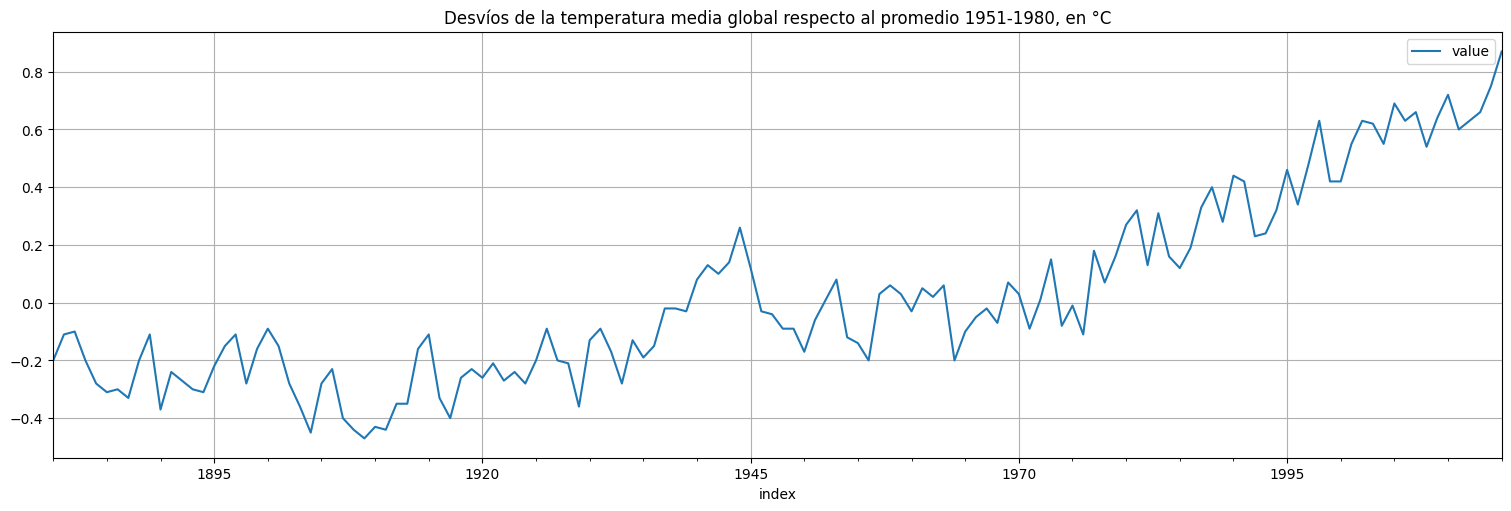

In [3]:
globtemp = astsa.globtemp
globtemp.plot();
plt.title("Desvíos de la temperatura media global respecto al promedio 1951-1980, en °C");

### Estado y observación:

   * La serie presenta una evolución temporal *lenta* correspondiente a la temperatura media.
   * Pero presenta variaciones anuales *rápidas* de mayor varianza producto de la observación.
  
#### Modelo:

   * Sea $x_t$ la tendencia central de la temperatura e $y_t$ la temperatura real medida.
   * Propongamos un modelo de la forma:
    
   $$\begin{cases} x_{t+1} = \phi x_t + w_t, \\ y_{t} = ax_t + v_t, \end{cases}$$
   
   con $\phi$ y $a$ parámetros a ajustar, $w_t$ y $v_t$ ruido blanco de varianzas $\sigma_w^2$ y $\sigma_v^2$, también a ajustar.

### Problemas para la estimación:

Tenemos $4$ parámetros a ajustar: $\phi$, $a$, $\sigma_w^2$ y $\sigma_v^2$. Si **supiéramos la secuencia** de estados $x_t$, entonces:

 * La ecuación de $x_t$ es un AR(1) de parámetros $\phi$ y $\sigma_w^2$. Se podría ajustar como vimos anteriormente.
 * $y_t-ax_t = v_t$ por lo que dicho residuo debería ser ruido blanco de varianza $\sigma_v^2$ que podríamos estimar.
 
 
> **Problema:**
>
>Solo conocemos $y_t$. ¿Cómo podemos reconstruir el valor "más probable" de $x_t$ a partir de estos datos?

## Estimación de estados

Un primer problema entonces es, dados:

* Un modelo conocido de estado-observación como el anterior.
* un conjunto de observaciones $\{y_1,\ldots,y_n\} = y^n$ hasta tiempo $n$, 

como estimar el valor de $x_t$ subyacente.


**Notación:**

* Si $t=n$ el problema se llama *filtrado* (filtering), es decir recuperar el *estado actual* con las observaciones hasta ahora.
* Si $t<n$, el problema se llama *suavizado* (smoothing) porque puedo usar información del futuro para recuperar el estado.
* Si $t>n$, tenemos el problema de *predicción*.

La solución a este problema es el **filtro de Kalman** o el **suavizador de Kalman**, según el caso.


### Filtro de Kalman

Comencemos con el caso $n=t$, en este caso queremos hallar el mejor estimador de $x_t$ usando $y_1,\ldots,y_t$. El mejor estimador en términos de error cuadrático medio es:

$$x_t^t = E[x_t \mid y^t]$$

y la varianza del error de estimación está dada por:

$$P^t_{t} = E\left[(x_{t}-x_{t}^t)^2\right].$$

En el caso Gaussiano, este estimador se puede hallar mediante una recursión denominada *filtro de Kalman*, que veremos a continuación para el modelo unidimensional anterior.


### Filtro de Kalman: modelo

Supongamos un modelo de la forma:

$$\begin{cases} x_{t+1} = \phi x_t + w_t, \\ y_t = ax_t + v_t \end{cases}$$

Con $\phi$ y $a$ dados, así como las varianzas de los ruidos $\sigma_w^2$ y $\sigma_v^2$. Supongamos que el proceso comienza en una condición inicial $x_0$ con distribución $N(\mu_0,\sigma_0^2)$.

El proceso se descompone en dos pasos, que luego se aplican de forma recursiva:

 * Conociendo la estimación $x_{t-1}^{t-1}$, realizo la *predicción a un paso* $x_{t}^{t-1}$ y estimo su varianza $P_{t}^{t-1}$.
 * Con la observación $y_t$, calculo la *diferencia* entre lo observado y lo que esperaba observar de acuerdo a la predicción realizada.
 * Se realiza la corrección de $x_{t}^{t-1}$ ponderando el error anterior por la *ganancia de Kalman* (el coeficiente adecuado), calculando $x_t^t$ y $P_t^t$.

### Filtro de Kalman, algoritmo.

Dado un modelo en espacio de estados como los anteriores, con condición inicial $N(\mu_0,\Sigma_0)$ realizamos la siguiente iteración:

1. Se fija $x_0^0 = \mu_0$ y $P_0^0 = \sigma_0^2$ es decir la estimación inicial corresponde a la media y varianza de la condición inicial.

2. Se actualiza la predicción del estado siguiente usando la info hasta $t-1$ y su error:

    $$\begin{align} x_t^{t-1} &= \phi x_{t-1}^{t-1} \\    
     P_{t}^{t-1} &= \phi^2 P_{t-1}^{t-1} + \sigma_w^2. \end{align}$$
    
    
3. Considero la nueva información $y_t$ y calculo la *innovación* o error de predicción:

    $$\epsilon_t = y_t - ax_t^{t-1}$$
       
4. *Corrijo la estimación* y construyo la nueva:
    $$\begin{align}x_t^t &= x_t^{t-1} + K_t (y_t - ax_t^{t-1}), \\
               P_{t}^{t} &= [1-K_ta] P_{t}^{t-1},\end{align}$$
    siendo
    
    $$ K_t = \frac{P_t^{t-1}a}{a^2P_t^{t-1} + \sigma_v^2}$$ 
    la *ganancia de Kalman*.

#### Otra interpretación:

La ecuación de actualización anterior se puede interpretar también como:

1. Propago la información hasta $t-1$ al paso siguiente:
    $$\begin{align} x_t^{t-1} &= \phi x_{t-1}^{t-1} \\    
     P_{t}^{t-1} &= \phi^2 P_{t-1}^{t-1} + \sigma_w^2. \end{align}$$

2. Mejoro la predicción haciendo una combinación lineal entre lo que observo y lo que estimo:

    $$x_t^t = x_t^{t-1} + K_t (y_t - ax_t^{t-1}) = (1-K_t a) x_t^{t-1} + K_t y_t = \frac{\sigma_v^2}{a^2P_t^{t-1} + \sigma_v^2}x_t^{t-1} + \frac{a^2P_t^{t-1}}{a^2P_t^{t-1} + \sigma_v^2} y_t$$

### Ejemplo (local level model):

Tomemos un modelo *conocido* y apliquemos el procedimiento anterior. Para ello, consideremos el llamado *local level model*:

$$\begin{cases} x_{t+1} = x_t + w_t, \\ y_t = x_t + v_t. \end{cases}$$

Es decir, tomemos $\phi=1$, $a=1$ y el estado es entonces un paseo al azar con ruido de varianza $\sigma_w^2$. Pero éste es medido a través de un ruido de varianza $\sigma_v^2$.

**Observación:** si $\sigma_w^2\ll \sigma_v^2$, tenemos un paseo al azar que se mueve *lentamente* pero que observamos con mucho ruido. Sirve para extraer tendencias centrales. El filtro debería *promediar* las observaciones cercanas para eliminar el ruido de observación y recuperar el estado.

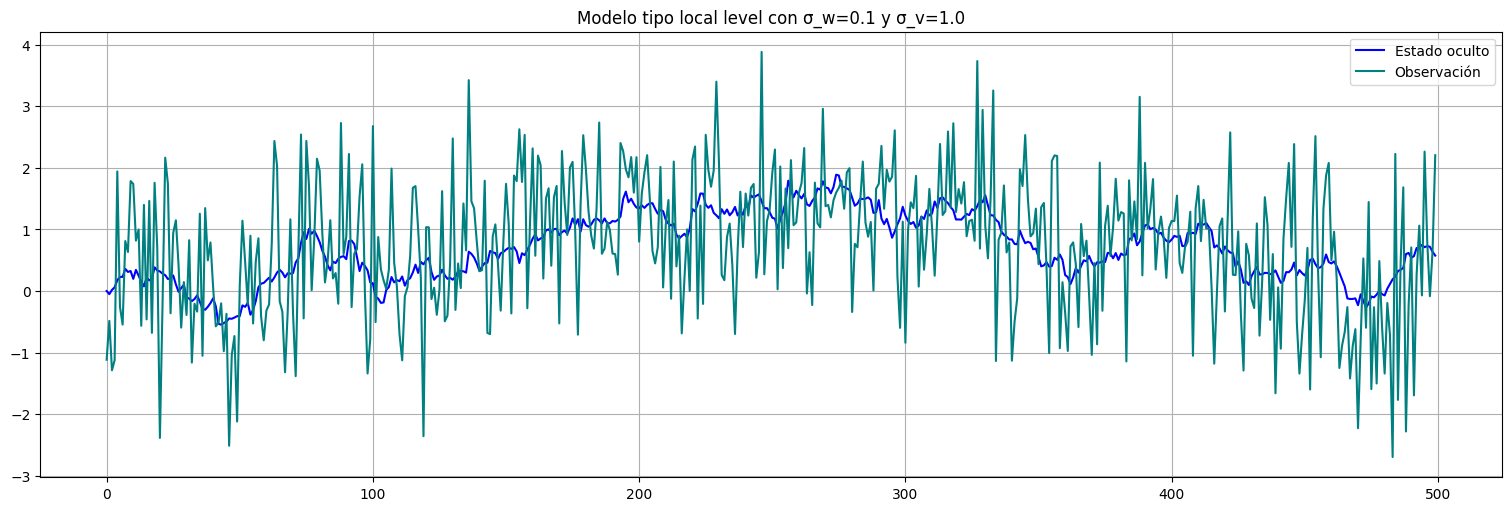

In [4]:
n=500 #cant de observaciones
sigmaw = 0.1
sigmav = 1.0
x0 = 0 #condición inicial

w=np.random.normal(0,sigmaw,n-1) #ruido blanco
x = np.concatenate(([x0],np.cumsum(w))) #genero el x acumulando los ruidos, esto es el paseo al azar de base

v=np.random.normal(0,sigmav,n) #ruido de observación
y=x+v #genero la observación

x=pd.Series(x)
y=pd.Series(y)

x.plot(color="blue", label="Estado oculto")
y.plot(color="teal", label="Observación")
plt.title(f"Modelo tipo local level con σ_w={sigmaw} y σ_v={sigmav}");
plt.legend();

### Aplicación del filtro de Kalman

La biblioteca `statsmodels.tsa` ya tiene varios modelos de espacio de estados pre-implementados, entre ellos el Local Level Model. Es un caso particular del modelo `UnobservedComponents`. En este caso, creamos un modelo de tipo `'local level'` y le fijamos los parámetros para que use los verdaderos (más adelante veremos cómo estimarlos).

En este modelo los parámetros se llaman:
 * `'sigma2.irregular'` que corresponde a $\sigma_v^2$.
 * `'sigma2.level'` que corresponde a $\sigma_w^2$.

In [5]:
from statsmodels.tsa.api import UnobservedComponents
model = UnobservedComponents(y, 'local level')
#Hago el fit, pero en realidad le fijamos todos los parámetros:
fit = model.fit_constrained({'sigma2.irregular': sigmav**2, 'sigma2.level': sigmaw**2})
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                      y   No. Observations:                  500
Model:                    local level   Log Likelihood                -730.678
Date:                Mon, 11 Nov 2024   AIC                           1461.356
Time:                        01:32:28   BIC                           1461.356
Sample:                             0   HQIC                          1461.356
                                - 500                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
sigma2.irregular (fixed)     1.0000        nan        nan        nan         nan         nan
sigma2.level (fixed)         0.0100        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.43   Jarque-Bera (JB):                 0.15
Prob(Q):                              0.51   Prob(JB):                         0.93
Heteroskedasticity (H):               1.04   Skew:                             0.04
Prob(H) (two-sided):                  0.81   Kurtosis:                         2.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Luego mediante la función `get_prediction` podemos obtener las predicciones

**Importante:** el parámetro `information_set` indica si queremos filtrar, suavizar o predecir. En este caso filtraremos:

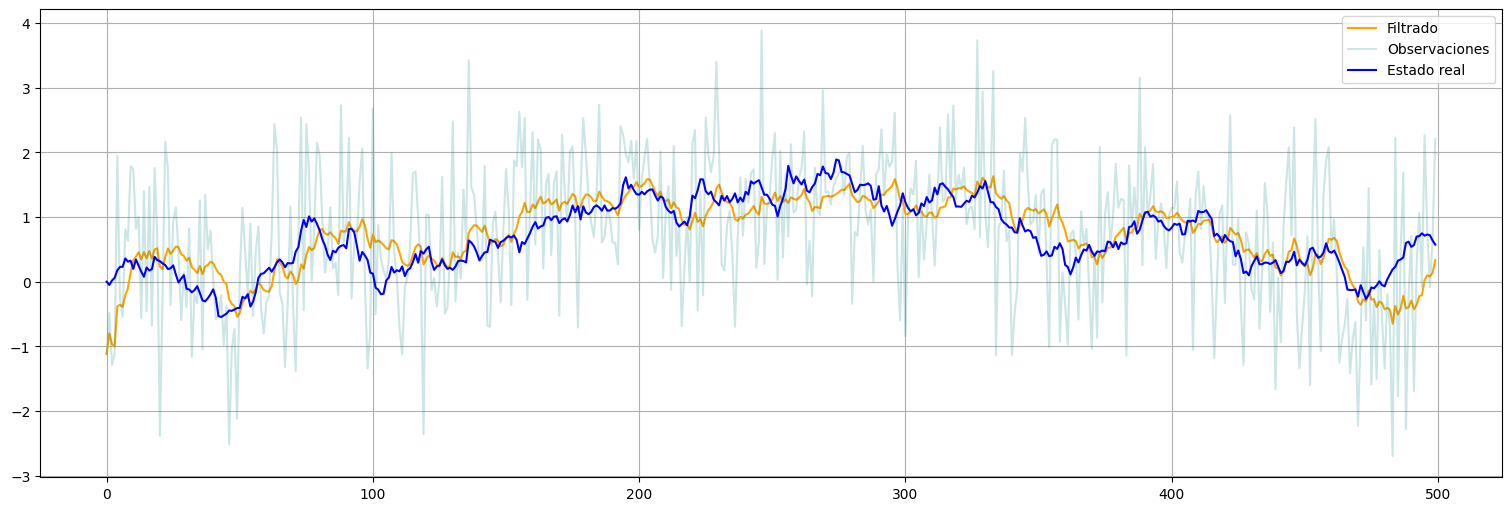

In [6]:
filtered = fit.get_prediction(0,n-1, information_set="filtered")
xhat = filtered.predicted_mean
xhat = pd.Series(xhat)
xhat.plot(color="orange", label="Filtrado")
y.plot(alpha=0.2, color="teal", label="Observaciones")
x.plot(color="blue", label="Estado real")
plt.legend();

También podemos obtener intervalos de confianza para los valores de observación:

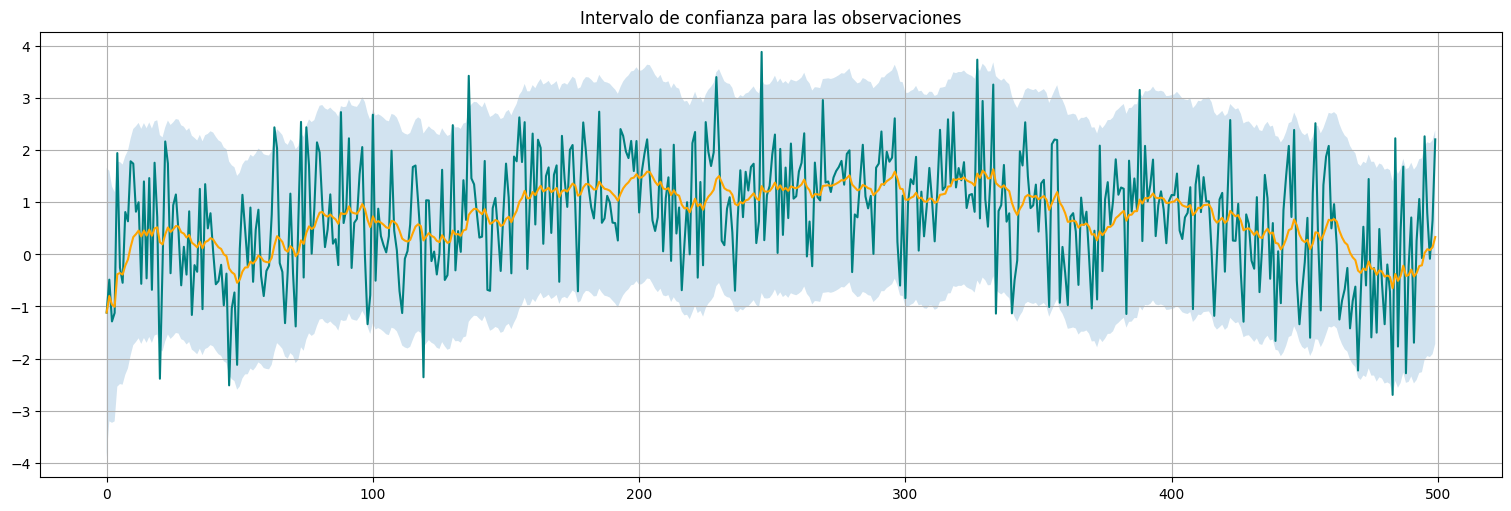

In [7]:
confint = filtered.conf_int()
y.plot(color="teal")
xhat.plot(color="orange")
plt.fill_between(x.index,confint["lower y"], confint["upper y"],alpha=0.2)
plt.title("Intervalo de confianza para las observaciones");

Y por último para los valores del estado oculto:

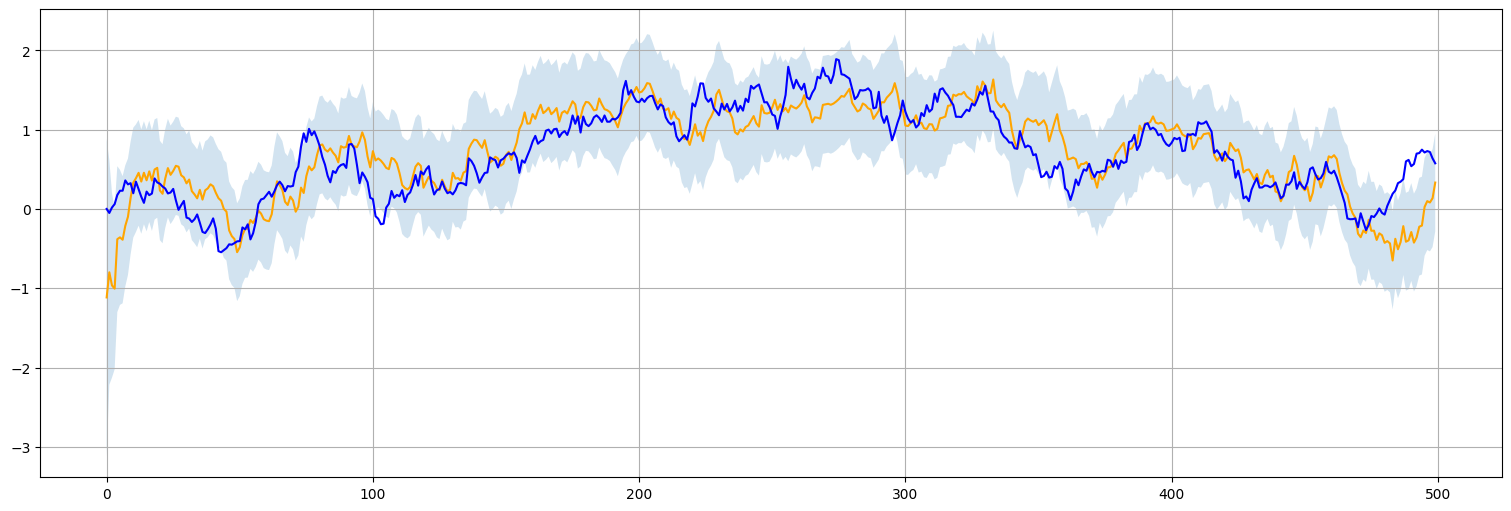

In [8]:
varxhat = fit.states.filtered_cov["level"].values
varxhat = pd.Series(varxhat)
xhat.plot(color="orange", label="Filtrado")
x.plot(color="blue", label="Estado real (oculto)")
plt.fill_between(x.index,xhat-2*np.sqrt(varxhat), xhat+2*np.sqrt(varxhat),alpha=0.2);

Veamos que la estimación $P_t^t$ de la varianza del estimador de estado está convergiendo también a un punto fijo:

In [9]:
fit.states.filtered_cov

level
level 0    0.999999
      1    0.502487
      2    0.338837
      3    0.258621
      4    0.211742
...             ...
      495  0.095125
      496  0.095125
      497  0.095125
      498  0.095125
      499  0.095125

[500 rows x 1 columns]

Es decir que el filtro en régimen está haciendo aproximadamente (recordar que $a=1$ en este caso):

$$x_t^t = \frac{\sigma_v^2}{P_t^t + \sigma_v^2}x_t^{t-1} + \frac{P_t^t}{P_t^t + \sigma_v^2} y_t.$$

O bien sustituyendo los valores $\sigma_v^2=1$ y $P_t^t\approx 0.1$ para nuestro caso:

$$x_t^t = \frac{1}{1.1}x_t^{t-1} + \frac{0.1}{1.1} y_t.$$

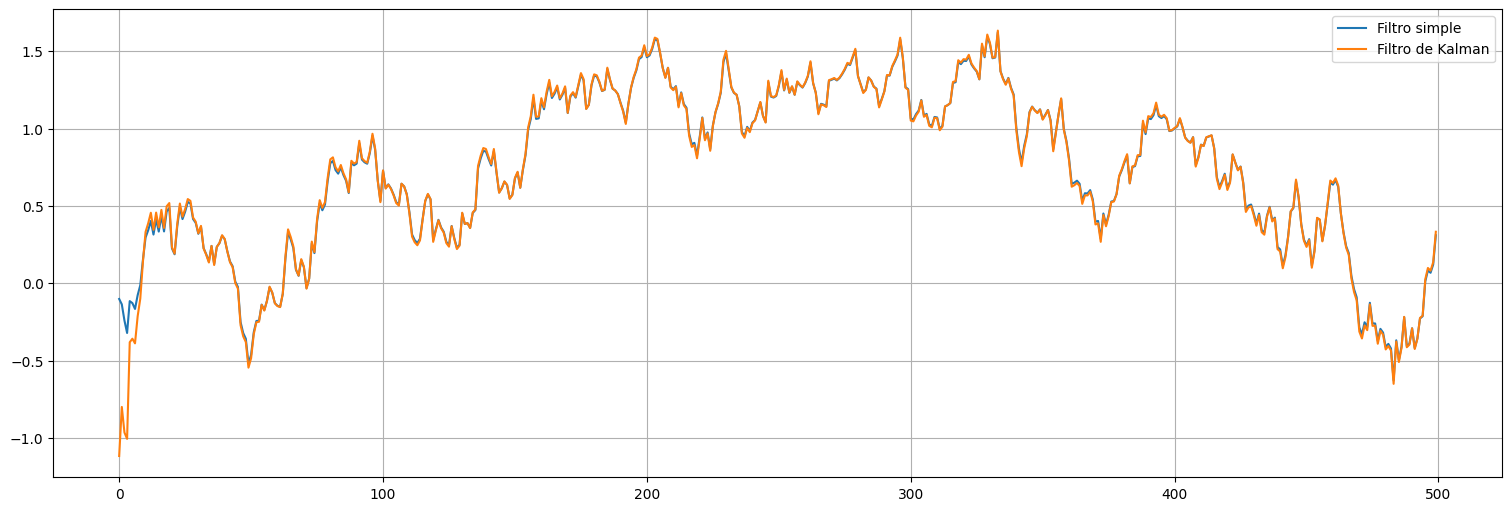

In [10]:
from scipy.signal import lfilter
x2 = lfilter([0.1],[1.1,-1],y)
x2 = pd.Series(x2)
x2.plot(label="Filtro simple")
xhat.plot(label="Filtro de Kalman")
plt.legend();

**Observación:** La idea del Filtro de Kalman es que descubre automáticamente los ponderadores óptimos!!!

### Análisis de residuos

Primero veamos el tamaño del error de estimación por filtrado:

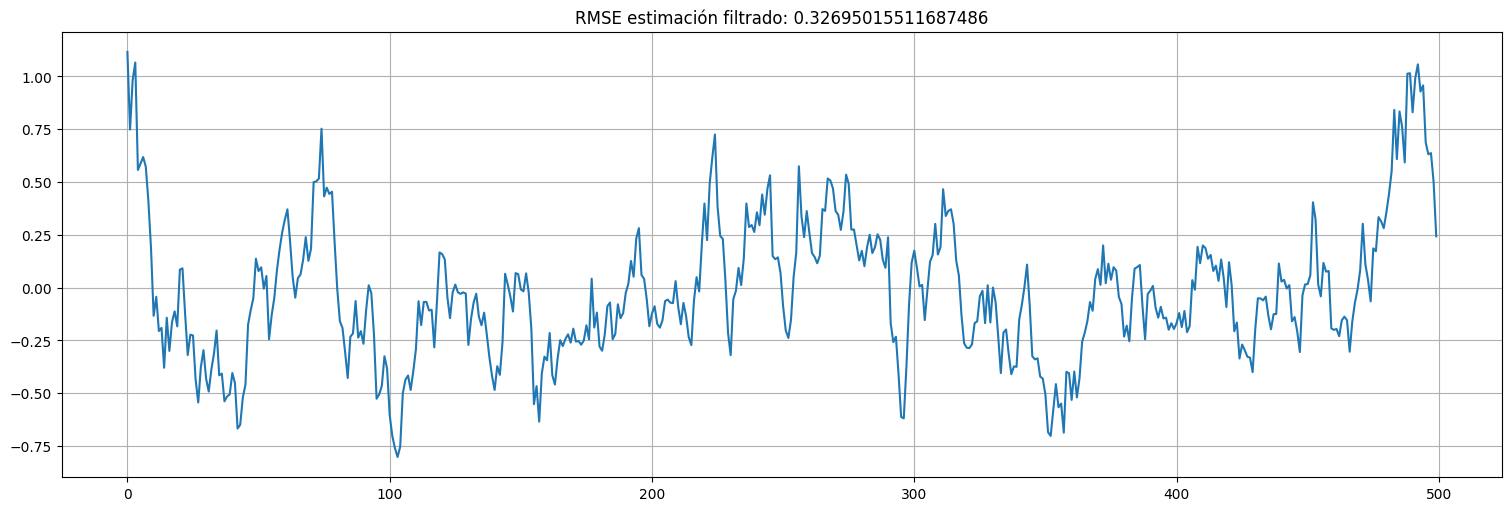

In [11]:
residuos = x - xhat
residuos.plot();
plt.title(f"RMSE estimación filtrado: {np.std(residuos)}");

#### Observación importante:

Uno esperaría que los residuos del filtrado, es decir $x_t - x_t^t$ queden ruido blanco, pero esto no es así!

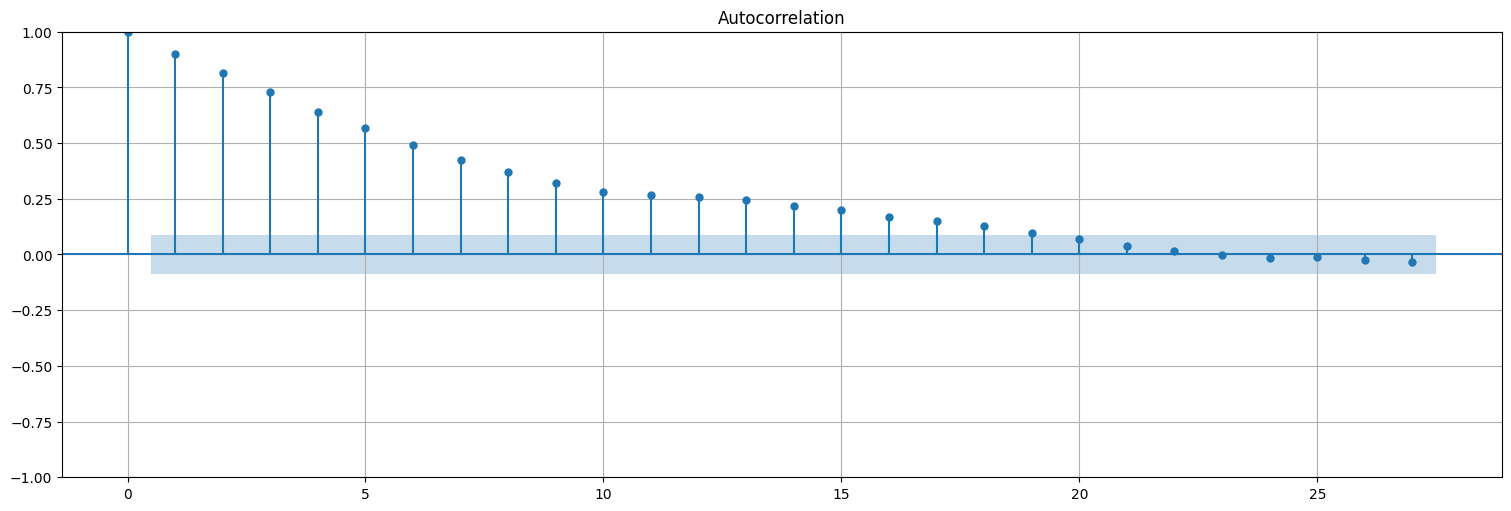

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(residuos, bartlett_confint=False);

**¿Por qué?** Porque usamos $y_t$ para calcular $x_t^t$ y este contiene información de $x_t$!

### Análisis de innovaciones:

Sin embargo, un subproducto del algoritmo es la secuencia de *innovaciones*:

$$\epsilon_t = y_t - ax_t^{t-1},$$

el *error de predicción a un paso* entre el $y_t$ observado y el que deberíamos haber observado en base a los datos *anteriores*. Este residuo, en las hipótesis de Kalman, debería ser **ruido blanco gaussiano** y podemos usarlo para chequear el ajuste. Para eso, usamos `information_set="predicted"` para ver la predicción a un paso recursiva:

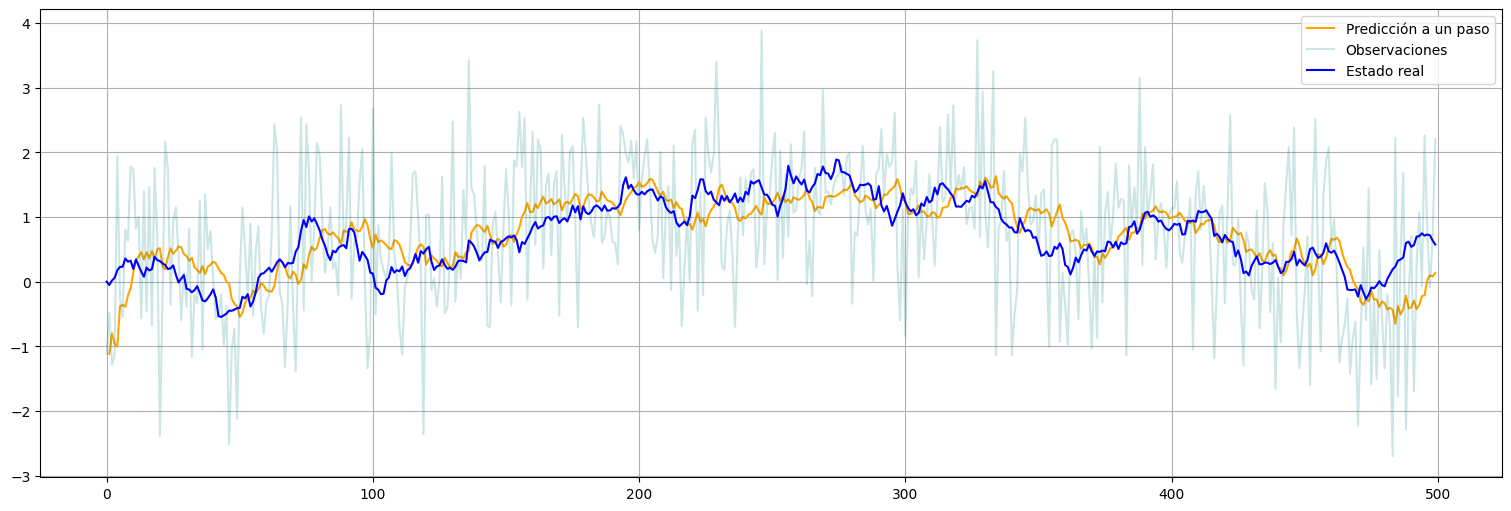

In [13]:
prediction = fit.get_prediction(1,n-1, information_set="predicted")
xpred = prediction.predicted_mean
xpred = pd.Series(xpred)
xpred.plot(color="orange", label="Predicción a un paso")
y.plot(alpha=0.2, color="teal", label="Observaciones")
x.plot(color="blue", label="Estado real")
plt.legend();

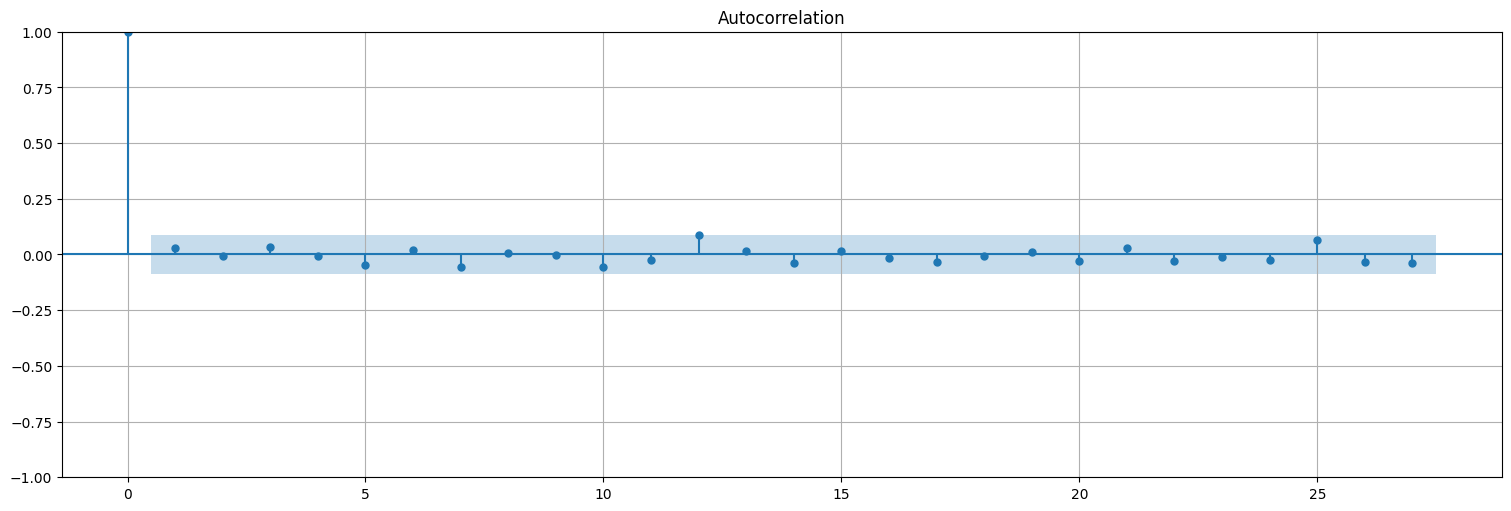

In [14]:
innov = (y-xpred).dropna()  #el dropna es para eliminar el primer valor de x que no lo predijimos.
plot_acf(innov, bartlett_confint=False);

De hecho, la función `plot_diagnostics` utiliza este residuo para hacer un chequeo de calidad del ajuste

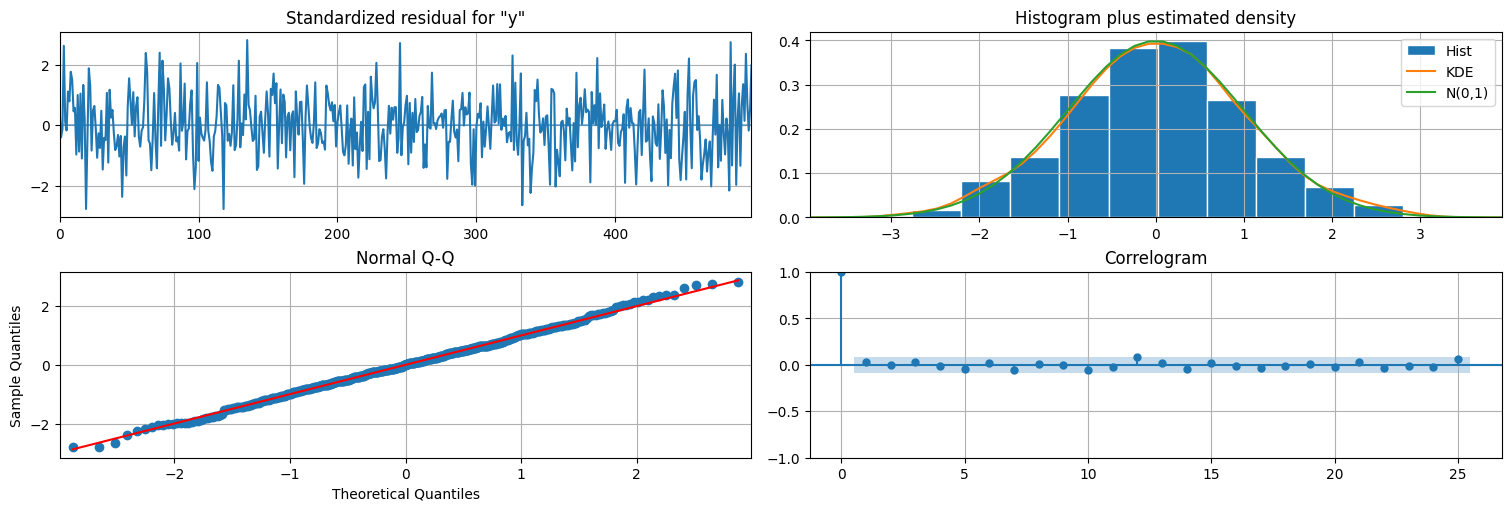

In [15]:
fit.plot_diagnostics(lags=25); #se puede pasar el parámetro lags=x para cambiar el largo del correlograma

Veamos que la predicción tiene un poco **más** de error que el filtrado:

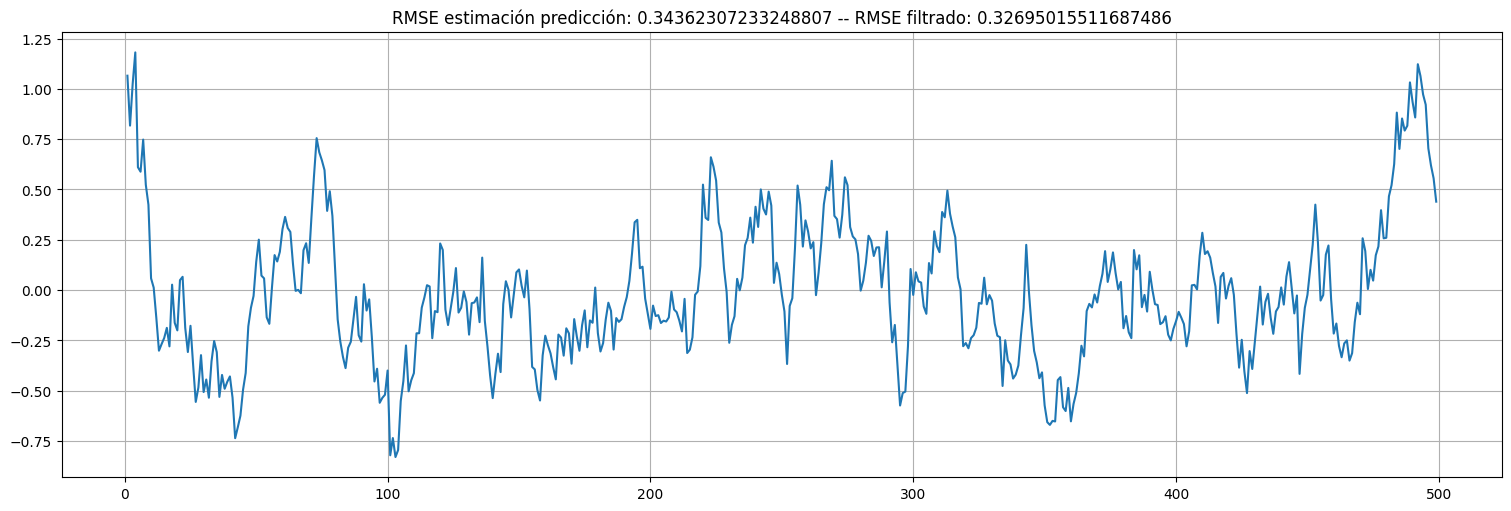

In [16]:
residuos_pred = x - xpred
residuos_pred.plot();
plt.title(f"RMSE estimación predicción: {np.std(residuos_pred)} -- RMSE filtrado: {np.std(residuos)}");

### Suavizador de Kalman

El procedimiento anterior usa la información de $y_0,\ldots,y_t$ para estimar $x_t$ de manera óptima. ¿Qué ocurre si tenemos información futura? ¿La podemos usar?

**Idea:** calcular $x_t^n = E[x_t\mid y^n] = E[x_t \mid y_0,\ldots,y_n]$ donde $t\leqslant n$.

Para hacerlo se usa el **suavizador de Kalman**. Es un procedimiento recursivo *hacia atrás*. Luego de obtener el filtrado anterior, se usa la información del futuro para volver a corregir la estimación.

### Suavizador de Kalman: procedimiento

Dados los datos $y_0,\ldots,y_n$ y el modelo:

 * Realizamos una pasada de filtrado (*forward*). En particular obtenemos $x^n_n$, la mejor estimación del estado final usando todos los datos, y su error $P_n^n$.
 
 * Se realiza una pasada hacia atrás (*backwards*), donde se corrigen recursivamente las estimaciones $x_t^t$ usando la información de $x_{t+1}^n$, la mejor estimación (ya corregida) del estado siguiente y su varianza.

### Suavizador de Kalman, algoritmo.

Para un modelo en espacio de estados como el que ya vimos y un conjunto de observaciones $\{y_1,\ldots,y_n\} = y^n$:

1. Se corre el filtro de Kalman hasta hallar $x^n_n$ y $P_n^n$.
2. Se itera $t=n,n-1,\ldots,1$ corrigiendo la estimación del filtro $x_{t}^t$ usando la información del futuro:
 
 $$ x^n_{t} = x_{t}^{t} + J_{t}(x^n_{t+1} - x_{t+1}^{t}),$$
 
 $$ P^n_{t} = P^{t}_{t} + J_{t}^2\left(P_{t+1}^n − P_{t+1}^{t}\right).$$ 

siendo:
$$ J_{t} = \frac{P_{t}^{t}}{P^t_{t+1}}\phi$$
el factor de corrección.


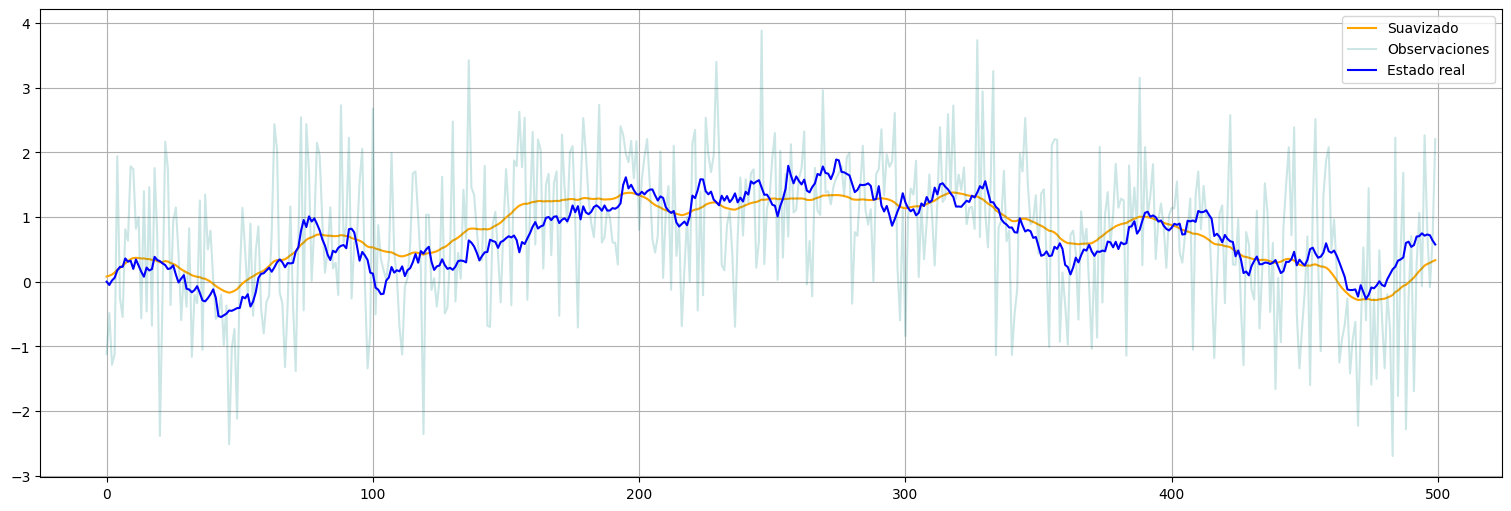

In [17]:
suavizado = fit.get_prediction(0,n-1, information_set="smoothed")
xs = suavizado.predicted_mean
xs = pd.Series(xs)
xs.plot(color="orange", label="Suavizado")
y.plot(alpha=0.2, color="teal", label="Observaciones")
x.plot(color="blue", label="Estado real")
plt.legend();

### Error de suavizado

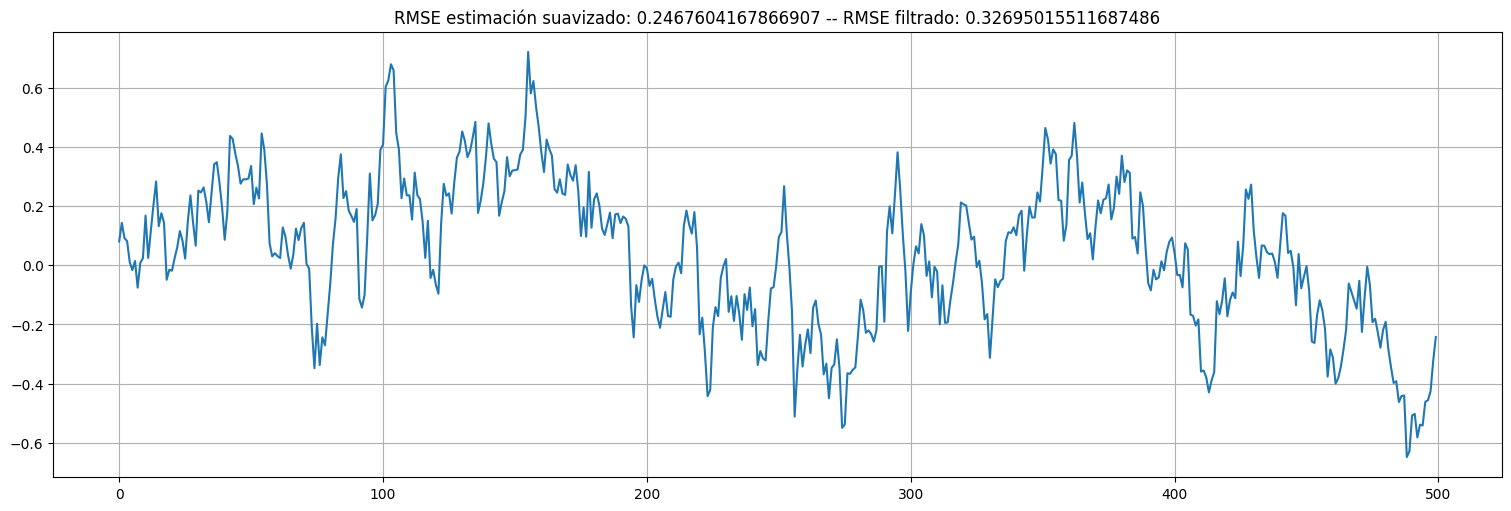

In [18]:
residuos_smooth = xs - x
residuos_smooth.plot();
plt.title(f"RMSE estimación suavizado: {np.std(residuos_smooth)} -- RMSE filtrado: {np.std(residuos)}");

## Ajuste por máxima verosimilitud

El procedimiento de filtrado y/o suavizado funciona *una vez que conocemos el modelo*. ¿Cómo podemos ajustar los parámetros?

> **Idea: ajuste por máxima verosimilitud.**
>
>  * Para un modelo dado, podemos estimar las innovaciones $\{\epsilon_t\}$ mediante el filtro.
>  * Las innovaciones son gaussianas independientes de media y varianza dadas. Podemos calcular su verosimilitud.
>  * Luego, mediante un algoritmo tipo gradiente vamos reestimando los parámetros $(\phi,a,\sigma_w,\sigma_v)$ para maximizarla.

### Ejemplo: local level model

Supongamos que tenemos únicamente acceso a la serie $y_t$ anterior pero no todos sus parámetros:

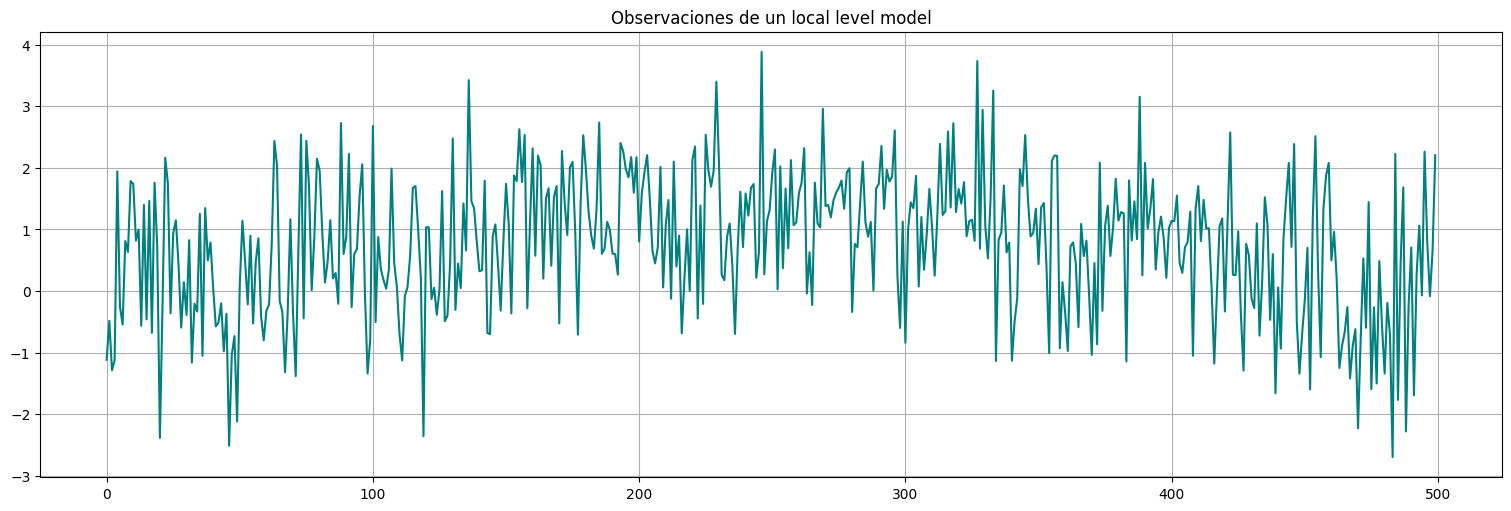

In [19]:
y.plot(color="teal")
plt.title("Observaciones de un local level model");

### Ejemplo: parámetros a ajustar

Si es un local level model, sabemos que $\phi = 1$ y $a=1$ en la ecuación general:

$$\begin{cases} x_{t+1} = x_t + w_t, \\ y_t = x_t + v_t. \end{cases}$$

Resta ajustar $\sigma_w$ y $\sigma_v$.

**Nota:** el propio filtro de Kalman nos va dando las innovaciones $\epsilon_t$, por lo que podemos calcular la verosimilitud respecto a los parámetros libres y maximizarla. De hecho esto es lo que normalmente hace el `fit` de la biblioteca.

In [20]:
model = UnobservedComponents(y, 'local level') #al ser local level, phi=1, a=1.
#aquí lo llamamos sin fijar los parámetros, solo le damos una condición inicial "razonable"
#muchas veces los propios modelos ya traen formas de estimar estas condiciones iniciales automáticamente
fit = model.fit()   #Se puede usar por ejemplo: start_params=[np.var(y),0.1*np.var(y)]); 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54153D+00    |proj g|=  2.34110D-01

At iterate    5    f=  1.46117D+00    |proj g|=  5.60817D-02

At iterate   10    f=  1.46054D+00    |proj g|=  3.89822D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     13      1     0     0   3.898D-07   1.461D+00
  F =   1.4605387371244187     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


In [21]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                      y   No. Observations:                  500
Model:                    local level   Log Likelihood                -730.269
Date:                Mon, 11 Nov 2024   AIC                           1464.539
Time:                        01:32:46   BIC                           1472.964
Sample:                             0   HQIC                          1467.845
                                - 500                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     1.0095      0.067     15.163      0.000       0.879       1.140
sigma2.level         0.0058      0.003      2.063      0.039       0.000       0.011
===================================================================================
Ljung-Box (L1) (Q):                   1.16   Jarque-Bera (JB):                 0.09
Prob(Q):                              0.28   Prob(JB):                         0.96
Heteroskedasticity (H):               1.04   Skew:                             0.03
Prob(H) (two-sided):                  0.80   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Resultado del ajuste

Finalmente, con los valores ajustados podemos:

 * Correr una pasada más del suavizado para estimar el estado final.
 * Hacer un chequeo de residuos en las innovaciones calculadas.

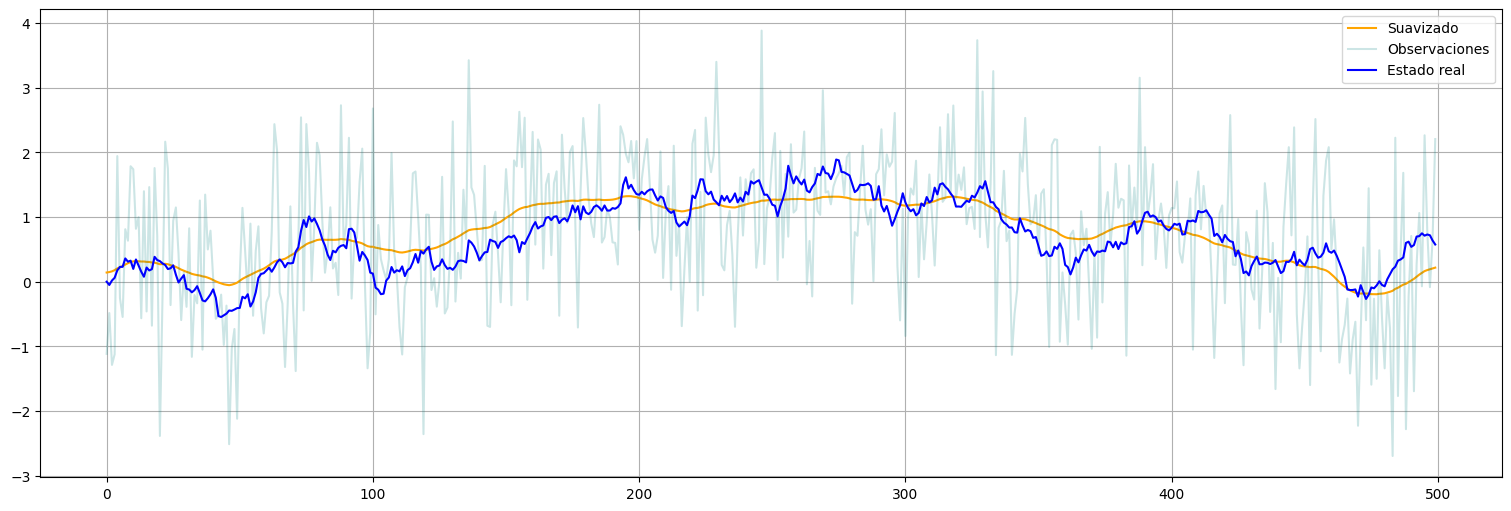

In [22]:
suavizado = fit.get_prediction(0,n-1, information_set="smoothed")

xs = suavizado.predicted_mean
xs = pd.Series(xs)
xs.plot(color="orange", label="Suavizado")
y.plot(alpha=0.2, color="teal", label="Observaciones")
x.plot(color="blue", label="Estado real")
plt.legend();

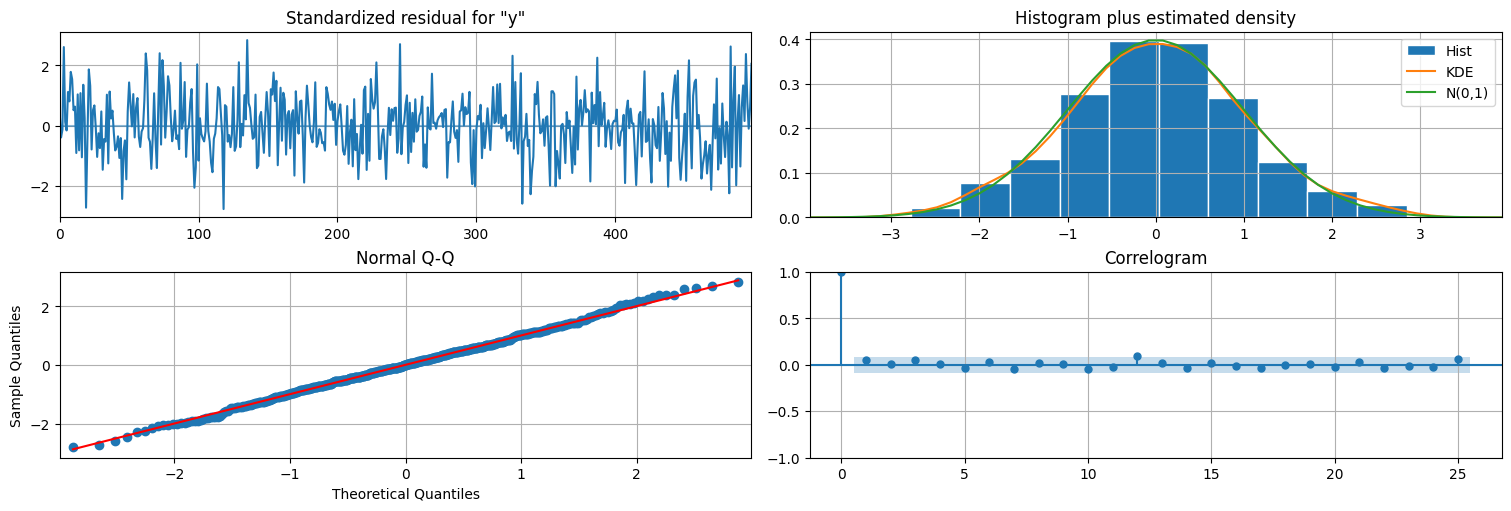

In [23]:
fit.plot_diagnostics(lags=25); #se puede pasar el parámetro lags=x para cambiar el largo del correlograma

## Modelo lineal dinámico: generalizaciones

El modelo básico anterior se puede generalizar de muchas maneras. Una básica para modelar tendencias es agregar una *entrada* $u_t$ conocida, que fuerza al estado y posiblemente a la observación.

   $$\begin{cases} x_{t+1} = \phi x_t + b u_t + w_t, \\ y_{t} = ax_t + cu_t + v_t, \end{cases}$$
   
   con $(\phi,a,b,c)$ parámetros y como antes $w_t$ y $v_t$ ruido blanco de varianzas $\sigma_w^2$ y $\sigma_v^2$, también parámetros.

### Ejemplo: calentamiento global

Volvamos a la serie de temperaturas globales vista antes:

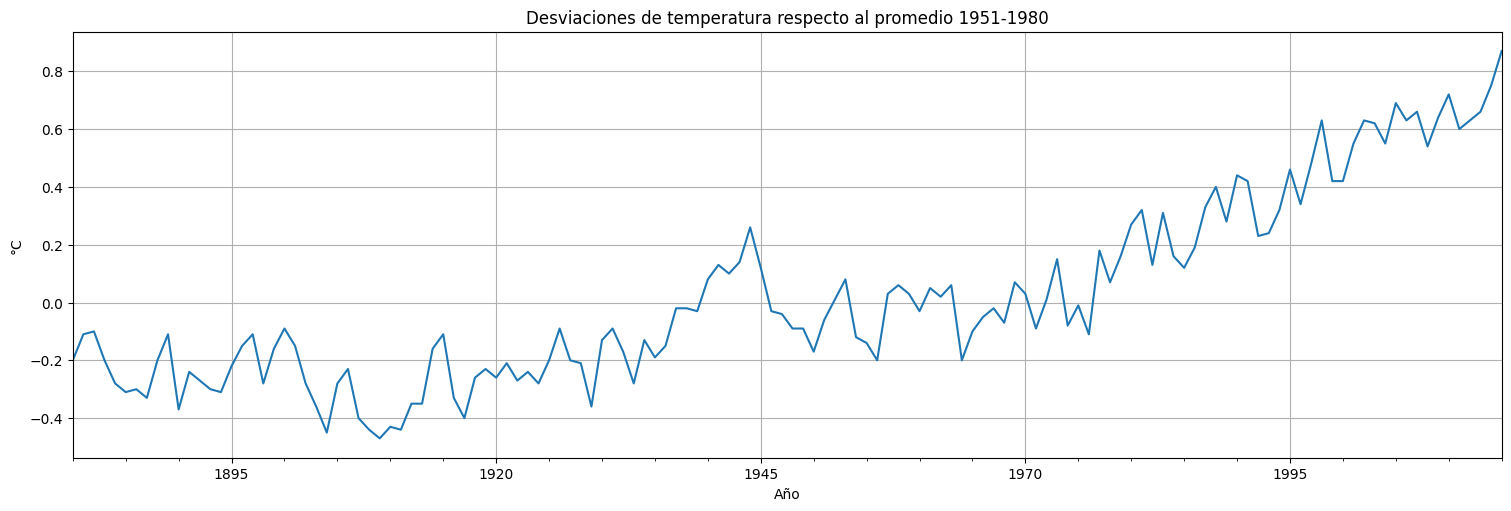

In [24]:
globtemp = pd.Series(astsa.globtemp["value"],name="globtemp")
globtemp.plot()
plt.xlabel("Año")
plt.ylabel("°C")
plt.title("Desviaciones de temperatura respecto al promedio 1951-1980");

### Modelo:

Supongamos que la serie tiene un estado $x_t$ que se mueve como un *paseo al azar con tendencia* y que además observamos a través de ruido. Matemáticamente:

   $$\begin{cases} x_{t+1} = x_t + \delta + w_t, \\ y_{t} = x_t + v_t, \end{cases}$$
   
Corresponde al modelo anterior con:

 * $\phi=1$, $a=1$.
 * $b = \delta$ y $u_t \equiv 1$ constante (tendencia constante, su valor $\delta$ no lo conocemos).
 * $c = 0$ ya que la tendencia no afecta la medida directamente.
 * $\sigma_w$ y $\sigma_v$ desconocidos.

### Creación del modelo:

El modelo anterior también es parte de los modelos de `UnobservedComponents` de la biblioteca, que debajo utilizan el filtro de Kalman, por lo que podemos repetir lo hecho anteriormente.

Este modelo se denomina `local linear deterministic trend` en la biblioteca. La referencia completa está en la [documentación oficial](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html).

In [25]:
model = UnobservedComponents(globtemp, 'local linear deterministic trend') #o lldtrend si quieren abreviar
#estos son los parámetros estocásticos a ajustar
#pero también ajusta el trend, lo considera un "intercept" en cada momento del tiempo.
model.param_names 

['sigma2.irregular', 'sigma2.level']

In [26]:
#Aca hacemos el fit y le damos dos valores iniciales razonables para empezar la optimización
fit = model.fit(start_params=[np.var(globtemp),0.1*np.var(globtemp)])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.07358D-03    |proj g|=  2.46395D+00

At iterate    5    f= -8.25544D-01    |proj g|=  2.85232D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     19      1     0     0   3.654D-04  -8.259D-01
  F = -0.82590555351155903     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


#### Importante: el fit nos muestra solo la parte de ajuste de varianzas.

In [27]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               Unobserved Components Results                                
============================================================================================
Dep. Variable:                             globtemp   No. Observations:                  136
Model:             local linear deterministic trend   Log Likelihood                 112.323
Date:                              Mon, 11 Nov 2024   AIC                           -220.646
Time:                                      01:32:52   BIC                           -214.851
Sample:                                  12-31-1880   HQIC                          -218.291
                                       - 12-31-2015                                         
Covariance Type:                                opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.0051      0.001      4.751      0.000       0.003       0.007
sigma2.level         0.0028      0.001      2.944      0.003       0.001       0.005
===================================================================================
Ljung-Box (L1) (Q):                   1.09   Jarque-Bera (JB):                 4.14
Prob(Q):                              0.30   Prob(JB):                         0.13
Heteroskedasticity (H):               1.20   Skew:                            -0.17
Prob(H) (two-sided):                  0.54   Kurtosis:                         2.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Extracción de la tendencia

En el caso del modelo `UnobservedComponents` la tendencia queda guardada en `fit.trend`. Como es una constante, tomamos el último valor y lo guardamos en `estimated_trend`, así como su varianza.

In [28]:
estimated_trend = fit.trend["smoothed"][-1]
print(f"Trend estimado: {estimated_trend}")
desvio = np.sqrt(fit.trend["smoothed_cov"][-1]) #tomo el último valor de varianza que es el que estima mejor.
print(f"Intervalo de confianza para el trend: [{estimated_trend-2*desvio},{estimated_trend+2*desvio}]")

Trend estimado: 0.0071956721642694055
Intervalo de confianza para el trend: [-0.0019370471891008,0.01632839151763961]


### Resultado del ajuste

Finalmente, con los valores ajustados podemos estimar la tendencia y chequear residuos:

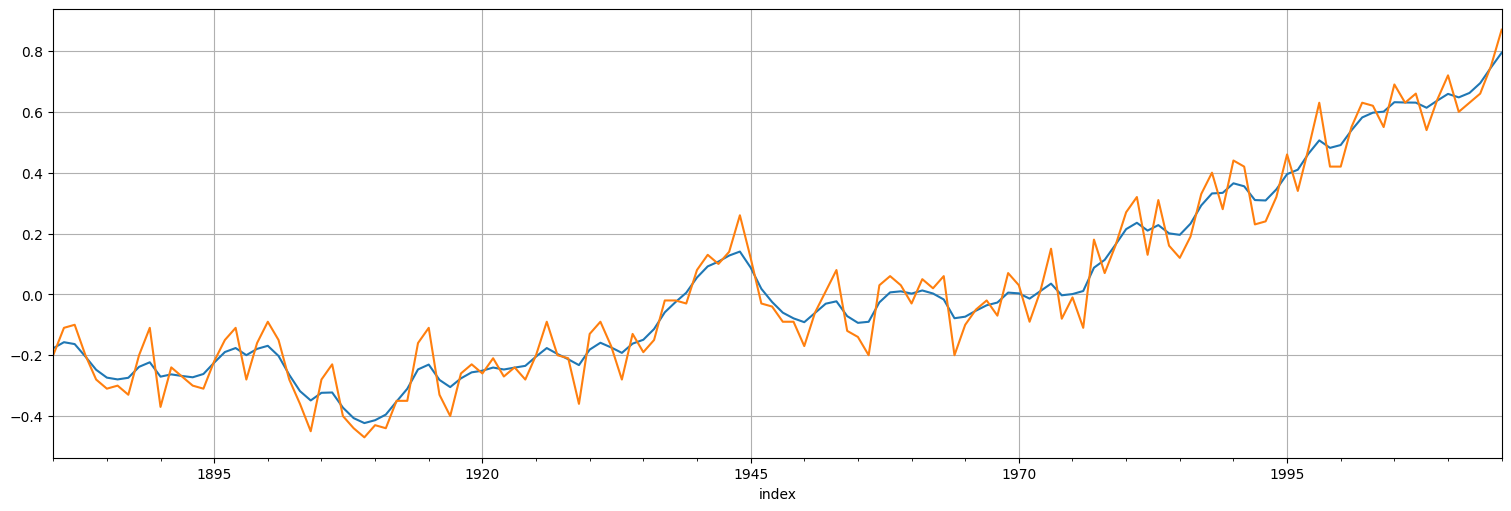

In [29]:
suavizado = fit.get_prediction(0,globtemp.size-1, information_set="smoothed")
xs = suavizado.predicted_mean
xs.plot()
globtemp.plot();

RMSE residuos de predicción a un paso: 0.10532736661993415


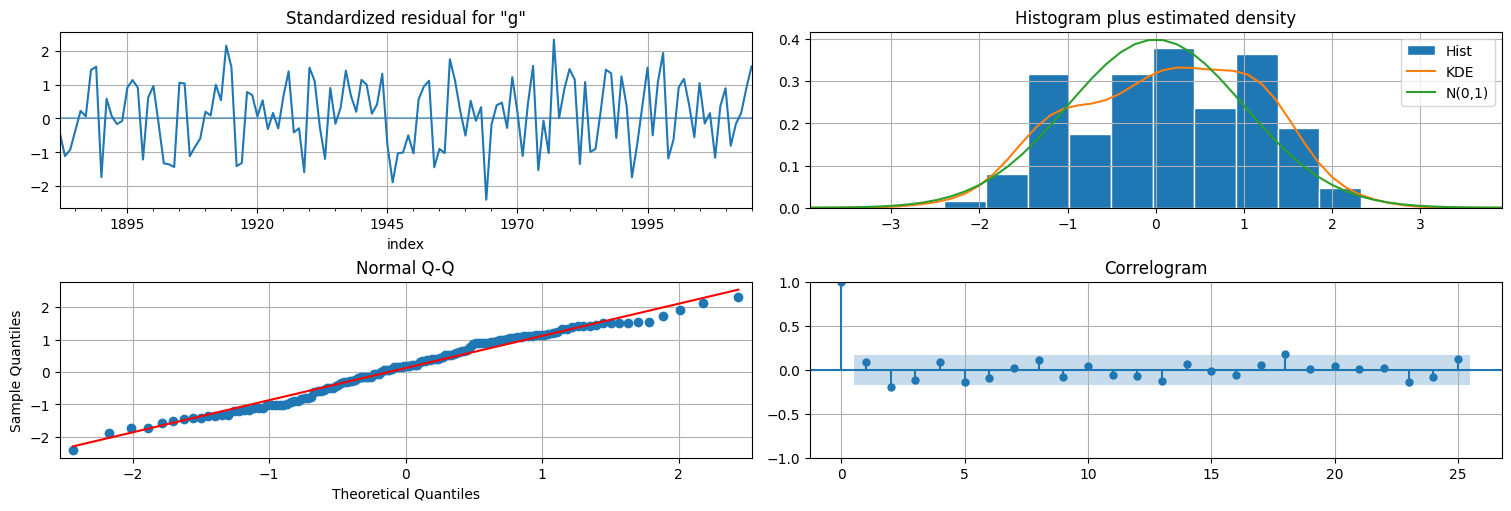

In [30]:
fit.plot_diagnostics(lags=25);
print(f"RMSE residuos de predicción a un paso: {np.sqrt(fit.mse)}")

### Observaciones

* El ajuste realizado es bueno. Las innovaciones quedan blancas y relativamente gaussianas.
* El ajuste de $\delta$ apenas modificó el valor, y el intervalo de confianza contiene al $0$ por lo que no hay evidencia suficiente de tendencia creciente!!

Podríamos probar correr nuevamente el ajuste forzando el $\delta=0$ a ver si los residuos quedan similares.

### Ejemplo: calentamiento global, segunda versión

Como el $\delta$ no nos quedó significativo, lo sacamos del modelo. Sin embargo, puede ser que $\phi$ no fuera $1$ y en realidad hubiera un crecimiento multiplicativo. Probemos esta nueva hipótesis ajustando:


   $$\begin{cases} x_{t+1} = \phi x_t + w_t, \\ y_{t} = x_t + v_t, \end{cases}$$
   
Corresponde al modelo anterior con:

 * $a=1$, $\phi$ desconocido.
 * Sin entrada, $b=c=0$.
 * $\sigma_w$ y $\sigma_v$ desconocidos.

### Estimación por máxima verosimilitud.

**Problema:** el modelo anterior no es ninguno de los modelos ya implementados en `statsmodels` por lo cual debemos crearlo!

La idea es extender la clase `MLEModel` con los parámetros adecuados. Consultar la [documentación](https://www.statsmodels.org/stable/statespace.html) ayuda...

In [31]:
# Construct the model
class myModel(sm.tsa.statespace.MLEModel):
    def __init__(self, endog):
        # Initialize the state space model
        super(myModel, self).__init__(endog, k_states=1, k_posdef=1, initialization='approximate_diffuse')

        # Setup the fixed components of the state space representation
        self['design'] = [1] #acá va la "a" que es 1
        self['selection'] = [1] #acá va lo que multiplique al ruido de observación, que es 1

        #los parámetros libres son [phi,sigma_w,sigma_v]
    @property
    def param_names(self):
        return ['phi','sigma2.level', 'sigma2.noise']

    #esta parte es para que restrinja las varianzas a ser positivas
    def transform_params(self, unconstrained):
        return unconstrained**2

    def untransform_params(self, constrained):
        return constrained**0.5
        
    # Describe how parameters enter the model
    def update(self, params, transformed=True, **kwargs):
        params = super(myModel, self).update(params, transformed, **kwargs)

        self['transition', 0, 0] = params[0]
        self['state_cov', 0, 0] = params[1]
        self['obs_cov', 0, 0] = params[2]

    # Specify start parameters and parameter names
    @property
    def start_params(self):
        return [1,np.var(self.endog),np.var(self.endog)]  # initial estimates

In [32]:
# Create and fit the model
modelo = myModel(globtemp)
fit = modelo.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.25081D-01    |proj g|=  1.66629D+00

At iterate    5    f= -7.81515D-01    |proj g|=  7.71815D-01

At iterate   10    f= -7.93345D-01    |proj g|=  9.98934D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     26      1     0     0   9.190D-04  -7.934D-01
  F = -0.79338850846836451     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


In [33]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:               globtemp   No. Observations:                  136
Model:                        myModel   Log Likelihood                 107.901
Date:                Mon, 11 Nov 2024   AIC                           -209.802
Time:                        01:32:55   BIC                           -201.064
Sample:                    12-31-1880   HQIC                          -206.251
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
phi              1.0091      0.017     59.437      0.000       0.976       1.042
sigma2.level     0.0028      0.001      2.848      0.004       0.001       0.005
sigma2.noise     0.0051      0.001      4.724      0.000       0.003       0.007
===================================================================================
Ljung-Box (L1) (Q):                   1.08   Jarque-Bera (JB):                 4.12
Prob(Q):                              0.30   Prob(JB):                         0.13
Heteroskedasticity (H):               1.28   Skew:                            -0.17
Prob(H) (two-sided):                  0.41   Kurtosis:                         2.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Resultado del ajuste

Finalmente, con los valores ajustados podemos estimar la tendencia y chequear residuos:

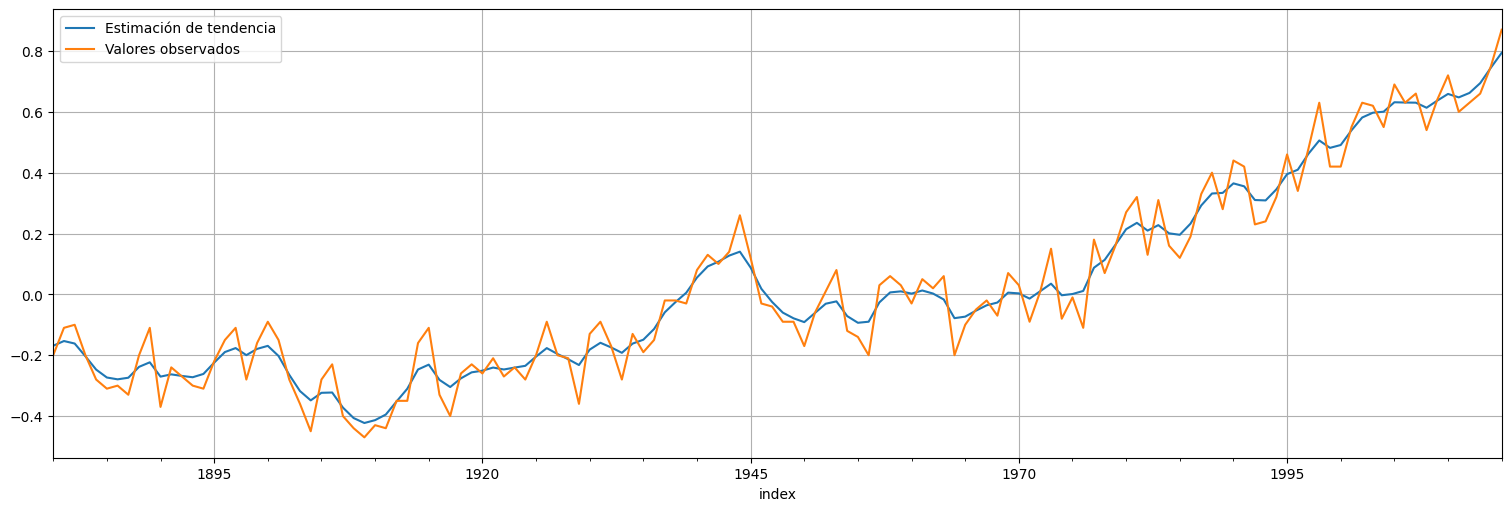

In [34]:
suavizado = fit.get_prediction(information_set="smoothed")
suavizado.predicted_mean.plot(label="Estimación de tendencia")
globtemp.plot(label="Valores observados")
plt.legend();

Chequeamos los residuos, es decir, las innovaciones del modelo:

RMSE residuos de predicción a un paso: 0.10368859214053858


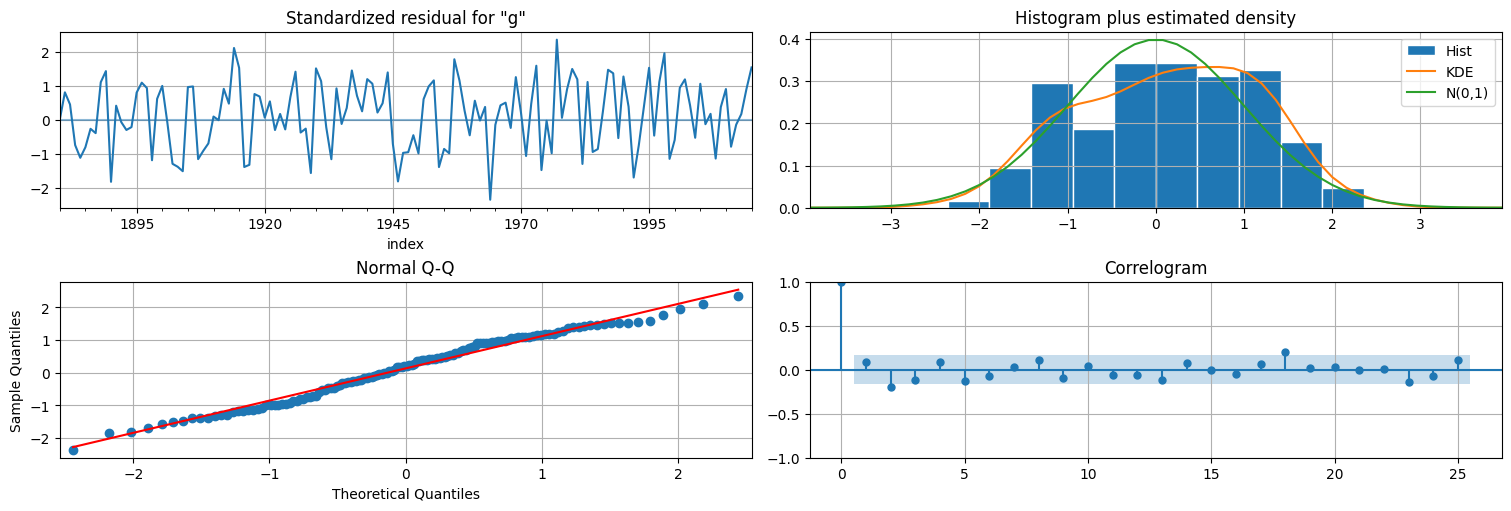

In [35]:
fit.plot_diagnostics(lags=25);
print(f"RMSE residuos de predicción a un paso: {np.sqrt(fit.mse)}")

### Observaciones

* El ajuste realizado es bueno. Las innovaciones quedan aproximadamente blancas y gaussianas.
* El RMSE del residuo no mejora demasiado (0.1036 vs 0.1054 en el caso anterior)
* El ajuste de $\phi$ apenas modificó el valor, y el intervalo de confianza contiene al $1$ por lo que no hay evidencia suficiente de que haya efecto multiplicativo!!!

In [36]:
cov = fit.cov_params()
cov

phi  sigma2.level  sigma2.noise
phi           0.000288 -3.684809e-06  1.442995e-06
sigma2.level -0.000004  9.566928e-07 -2.318104e-07
sigma2.noise  0.000001 -2.318104e-07  1.147667e-06

In [37]:
phiest = fit.params["phi"]
phiest_var = fit.cov_params().iloc[0,0] #saco la varianza de la estimación de phi

print(f"Valor estimado de ϕ = {phiest}")
print(f"Intervalo de confianza para ϕ = [{phiest-2*np.sqrt(phiest_var)},{phiest+2*np.sqrt(phiest_var)}]")

Valor estimado de ϕ = 1.0091119877109902
Intervalo de confianza para ϕ = [0.9751564760025883,1.0430674994193923]


**Disclaimer:** No estoy negando (ni afirmando) el calentamiento global! No todavía...

### Predicción a futuro

Finalmente podemos hacer una predicción a futuro con el modelo ajustado.

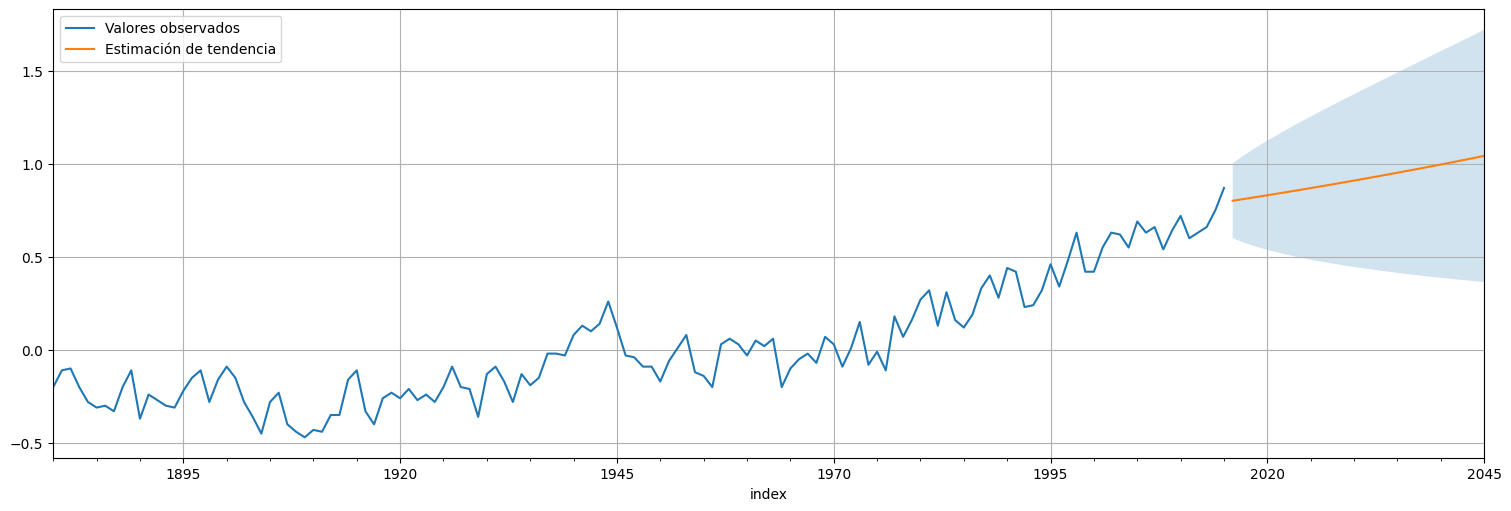

In [38]:
forecast = fit.get_forecast(30)
globtemp.plot(label="Valores observados")
forecast.predicted_mean.plot(label="Estimación de tendencia")
confint = forecast.conf_int()
plt.fill_between(confint.index,confint["lower globtemp"],confint["upper globtemp"],alpha=0.2)
plt.legend();

## Ejemplo con variables explicativas

Consideremos las series `oil` y `gas` de la biblioteca, transformadas por $\log$:

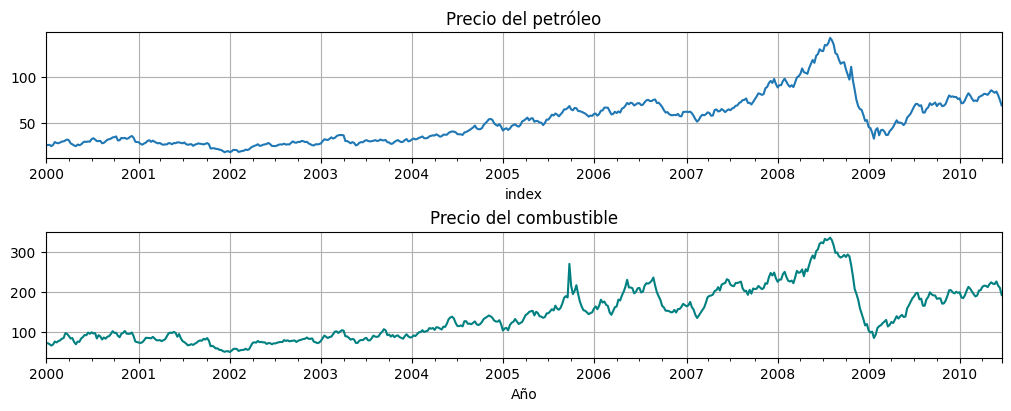

In [39]:
oil = astsa.oil
gas = astsa.gas
fig, axs = plt.subplots(2, 1, figsize=[10,4])
oil.plot(ax=axs[0], title="Precio del petróleo", legend=False)
gas.plot(ax=axs[1], title="Precio del combustible", color="teal", xlabel="Año", legend=False);

### Modelo

Supongamos que el valor de `gas` puede explicarse a partir de factores $x_t$ no conocidos, que evolucionan de manera autorregresiva, y del valor actual y anterior de `oil` que eran los que habíamos visto en la correlación cruzada como significativos.

Llamemos $x_t$ al factor no conocido, $y_t$ al valor observado de `gas` y $u_t$ el valor de oil que vamos a usar para explicar. Proponemos entonces el modelo:

$$x_{t+1} - \mu = \phi (x_t - \mu) + w_t$$
$$y_t = x_t + a u_t + b u_{t-1} + v_t$$

Debemos estimar $\mu$, $\phi$, $a$, $b$ y las varianzas de los ruidos $\sigma_w^2$ y $\sigma_v^2$

Llevado a la forma estándar el modelo es:

$$x_{t+1} = \phi x_t + \mu(1-\phi) + w_t$$
$$y_t = x_t + a u_t + b u_{t-1} + v_t$$

Los parámetros quedan acoplados, recordemos que debemos estimar $\mu$, $\phi$, $a$, $b$ y las varianzas de los ruidos $\sigma_w^2$ y $\sigma_v^2$

Aparecen dos problemas:
 1. Debemos implementar el modelo, extendiendo la clase MLEModel
 2. Debemos conseguir una buena estimación inicial de los parámetros

Comencemos por el 2o. problema, la estimación inicial. Para eso supongamos que $x_t=\mu$ constante, entonces:

$$y_t = \mu + a u_t + bu_{t-1} + v_t$$

Esto es un modelo lineal, podemos ajustarlo y tener una idea inicial de $\mu, a,b,\sigma_v^2$!

In [40]:
from statsmodels.formula.api import ols

data = pd.concat([gas,oil, oil.shift()], axis=1).dropna()
data.columns = ["gas","oil","oilL1"]

fit = ols(formula="gas~oil+oilL1", data=data).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    gas   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     5981.
Date:                Mon, 11 Nov 2024   Prob (F-statistic):               0.00
Time:                        01:33:00   Log-Likelihood:                -2189.2
No. Observations:                 544   AIC:                             4384.
Df Residuals:                     541   BIC:                             4397.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.7257      1.308     10.490      0.000      11.155      16.296
oil            2.7391      0.225     12.173      0.000       2.297       3.181
oilL1         -0.2814      0.225     -1.251      0.211      -0.723       0.160
==============================================================================
Omnibus:                      221.894   Durbin-Watson:                   0.276
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1056.972
Skew:                           1.782   Prob(JB):                    3.03e-230
Kurtosis:                       8.825   Cond. No.                         185.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Del ajuste surge entonces nuestra estimación inicial. Usaremos $\sigma_w^2\approx \sigma_v^2$.

In [41]:
mu0 = fit.params["Intercept"]
a0 = fit.params["oil"]
b0 = fit.params["oilL1"]
sigmav2_0 = fit.mse_resid
sigmaw2_0 = fit.mse_resid

Construimos el modelo:

In [42]:
# Construct the model
class myModel(sm.tsa.statespace.MLEModel):
    def __init__(self, endog, **kwargs):
        # Initialize the state space model
        super(myModel, self).__init__(endog, k_states=1, k_posdef=1, initialization='approximate_diffuse', **kwargs)

        # Setup the fixed components of the state space representation
        self['selection'] = [1] #acá va lo que multiplique al ruido de estado, que es 1
        self['design'] = [1]
        self.positive_parameters = [4,5]
    
    @property
    def param_names(self):
        return ['phi', ' mu', 'a', 'b', 'sigma2.w', 'sigma2.v']

    #esta parte es para que restrinja las varianzas a ser positivas
    def transform_params(self, unconstrained):
        constrained = unconstrained.copy()
        constrained[self.positive_parameters] = constrained[self.positive_parameters]**2
        return constrained

    def untransform_params(self, constrained):
        unconstrained = constrained.copy()
        unconstrained[self.positive_parameters] = unconstrained[self.positive_parameters]**0.5
        return unconstrained
        
    # Describe how parameters enter the model
    def update(self, params, transformed=True, **kwargs):
        params = super(myModel, self).update(params, transformed, **kwargs)

        self['transition', 0, 0] = params[0] #actualizo el phi
        self['state_intercept',0,0] = (1-params[0])*params[1] #mu*(1-phi)
        self['obs_intercept'] = np.reshape(params[2] * self.exog[:,0] + params[3] * self.exog[:,1], (1, self.nobs))
        self['state_cov', 0, 0] = params[4]
        self['obs_cov', 0, 0] = params[5]

    # Specify start parameters and parameter names
    @property
    def start_params(self):
        return [1,mu0,a0,b0,sigmaw2_0,sigmav2_0]  # these are very simple initial estimates


In [43]:
exog = pd.concat([oil, oil.shift()], axis=1).dropna()
modelo = myModel(gas[1:],exog=exog)
fit = modelo.fit(maxiter=100)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.06883D+00    |proj g|=  3.03645D-01

At iterate    5    f=  3.90711D+00    |proj g|=  8.91933D-01

At iterate   10    f=  3.45383D+00    |proj g|=  1.36726D-01

At iterate   15    f=  3.33341D+00    |proj g|=  3.48398D-01

At iterate   20    f=  3.32113D+00    |proj g|=  9.43206D-03

At iterate   25    f=  3.31533D+00    |proj g|=  9.15048D-03

At iterate   30    f=  3.31476D+00    |proj g|=  2.35940D-03

At iterate   35    f=  3.31468D+00    |proj g|=  2.36443D-03

At iterate   40    f=  3.31440D+00    |proj g|=  1.19013D-02

At iterate   45    f=  3.31429D+00    |proj g|=  1.42877D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


In [44]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  value   No. Observations:                  544
Model:                        myModel   Log Likelihood               -1802.976
Date:                Mon, 11 Nov 2024   AIC                           3617.952
Time:                        01:33:03   BIC                           3643.746
Sample:                    01-09-2000   HQIC                          3628.037
                         - 06-20-2010                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
phi            0.8865      0.020     44.579      0.000       0.848       0.926
 mu           17.2823      6.724      2.570      0.010       4.103      30.462
a              2.1079      0.055     38.633      0.000       2.001       2.215
b              0.2874      0.097      2.964      0.003       0.097       0.477
sigma2.w      39.8598      2.596     15.356      0.000      34.772      44.947
sigma2.v       2.1159      1.281      1.651      0.099      -0.396       4.628
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             44820.68
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               4.66   Skew:                             2.67
Prob(H) (two-sided):                  0.00   Kurtosis:                        47.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

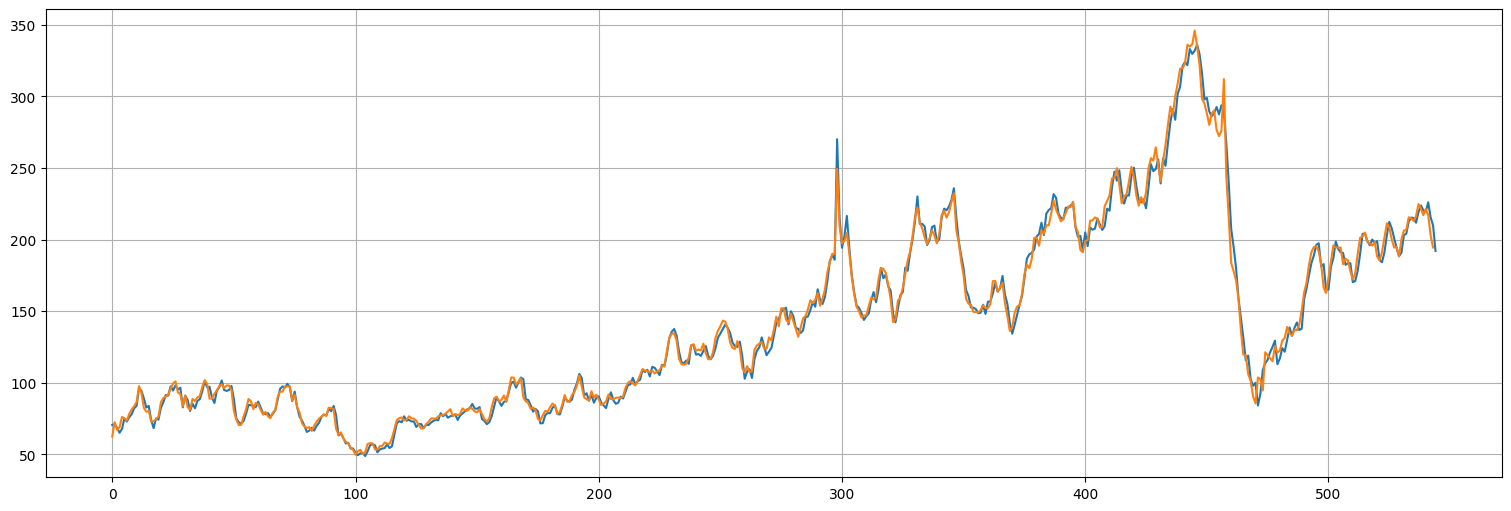

In [45]:
pred = fit.get_prediction()
plt.plot(gas.values)
plt.plot(pred.predicted_mean.values);

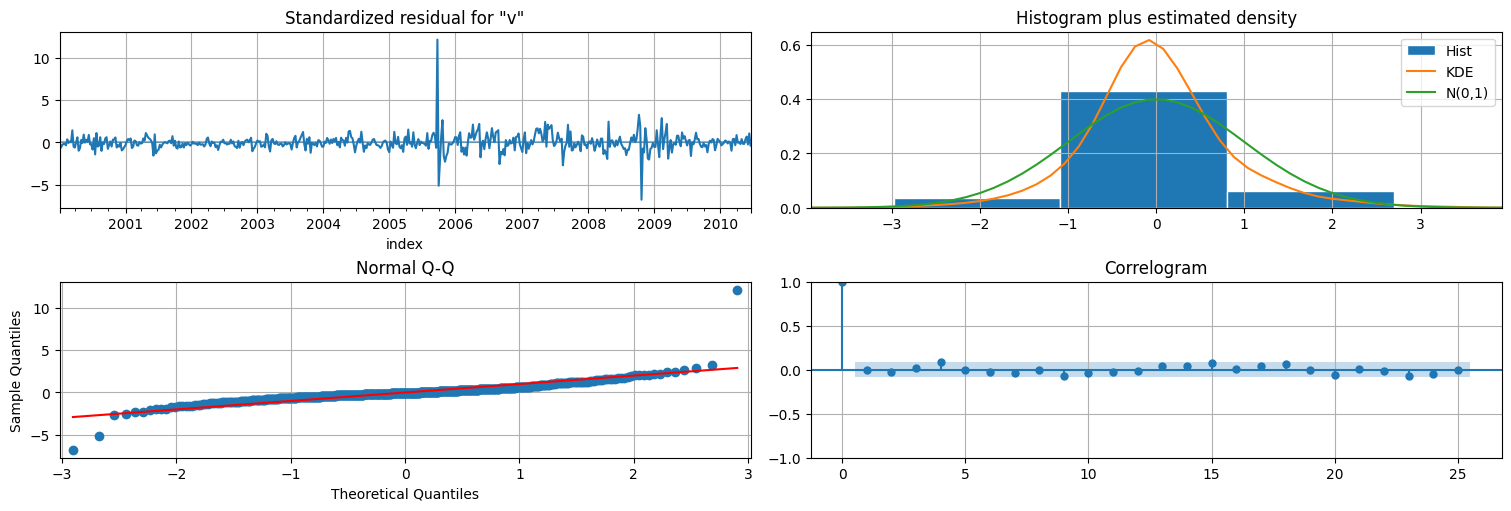

In [46]:
fit.plot_diagnostics(lags=25);

Ahora graficamos el factor desconocido:

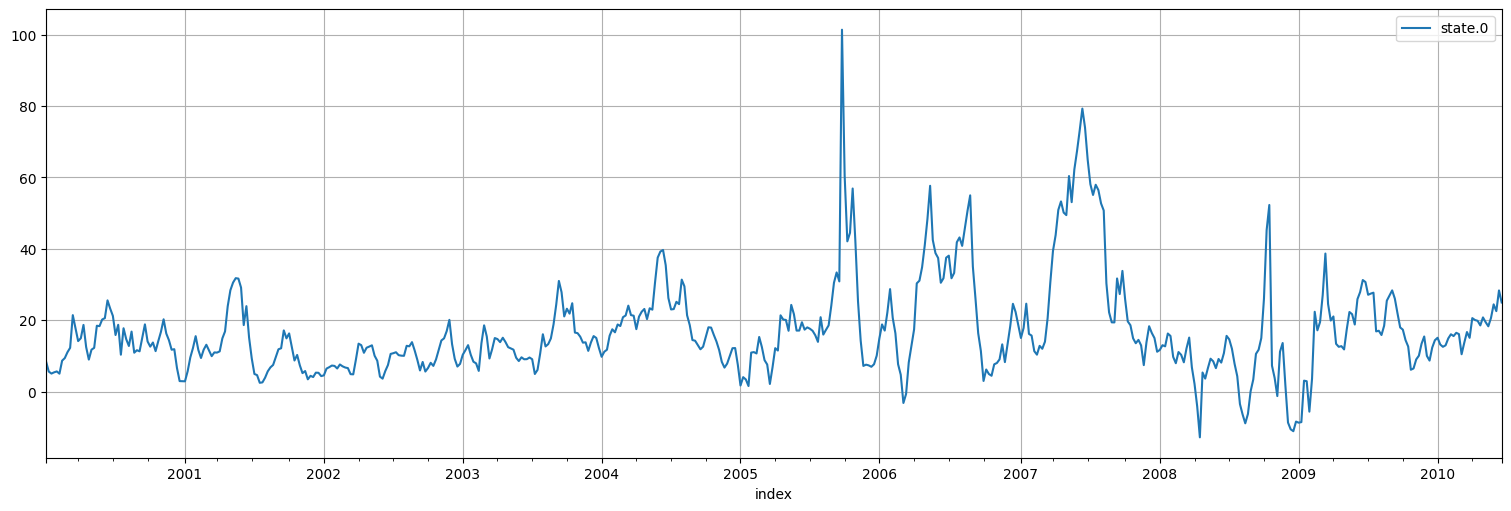

In [47]:
xhat = fit.states.smoothed
xhat.plot();

## Modelo lineal dinámico: el caso de múltiples estados.

La generalización completa del modelo lineal dinámico es considerar que podemos tener *múltiples estados* y *múltiples observaciones* ocurriendo en paralelo. Esto sirve en particular para modelar problemas físicos, donde la evolución del estado sigue una dinámica conocida.

> **Modelo Lineal Dinámico General:**
>
> $$ x_{t+1} = \Phi x_t + Bu_t + w_t.$$
>
> $$ y_t = A x_t + Cu_t + v_t,$$

* Aquí $x_t$ es un vector de tamaño $p$ con los estados, e $y_t$ un vector de tamaño $q$ con las observaciones.

* Por lo tanto $\Phi$ es una matriz de $p\times p$ que indica cómo calcular el estado siguiente a partir de los anteriores, y $A$ una matriz de $p\times q$ que indica cómo se calculan las observaciones.

* $u_t$ es una entrada vectorial de tamaño $r$ y $B$ (de $p\times r$) y $C$ (de $q\times r$) son matrices que dicen cómo afectan al estado y a la observación.

* Por último, $w_t$ y $v_t$ son ruidos blancos *vectoriales* de tamaños $p$ y $q$, con matriz de covarianzas $Q$ y $R$ cada uno.

### Reconstrucción del estado

Para reconstruir los estados $\{x_t\}$ a partir de las observaciones $\{y_t\}$ se plantean los mismos problemas que antes. Todas las técnicas vistas anteriormente funcionan, pero utilizando la versión *matricial* del filtro de Kalman que describimos a continuación.

**Notación:** denotemos por

 * $x_t^t = E[x_t \mid y^t]$, el vector estimación actual del estado.
 * $P_t^t = E[(x_t - x_t^t)(x_t-x_t^t)^T]$ la matriz de covarianzas de error (ahora es matricial, porque influencia cruzada de errores).

### Filtro de Kalman, versión matricial.

Dado un modelo en espacio de estados como los anteriores, con condición inicial $N(\mu_0,\Sigma_0)$ realizamos la siguiente iteración.

1. Se fija $x_0^0 = \mu_0$ y $P_0^0 = \Sigma_0$ es decir la estimación inicial corresponde a la condición inicial.

2. Se actualiza la predicción del estado siguiente usando la info hasta $t-1$ y su error:

    $$ x_t^{t-1} = \Phi x_{t-1}^{t-1} + B u_t, $$
    
    $$ P_{t}^{t-1} = \Phi P_{t-1}^{t-1} \Phi^T + Q.$$
    
3. Considero la nueva información $y_t$ y *corrijo la estimación*:

    $$ x_t^t = x_t^{t-1} + K_t (y_t - Ax_t^{t-1} - Cu_t), $$
    
    $$ P_{t}^{t} = [Id-K_tA] P_{t}^{t-1}.$$

    siendo $K_t = P_t^{t-1} A^T[AP_{t}^{t-1} A^T + R]^{-1}$ la *ganancia de Kalman*.
    
4. Si tengo $n$ muestras, itero 2 y 3 hasta $n$ la cantidad de muestras. Si continúo el paso 2 para $t>n$ construyo las predicciones.

### Suavizador de Kalman, versión matricial.

Para un modelo en espacio de estados matricial y un conjunto de observaciones $\{y_1,\ldots,y_n\} = y^n$:

1. Se corre el filtro de Kalman hasta hallar $x^n_n$ y $P_n^n$.
2. Se itera $t=n,n-1,\ldots,1$ corrigiendo la estimación de Kalman usando la información del futuro:
 
 $$ x^n_{t} = x_{t}^{t} + J_{t}(x^n_{t+1} - x_{t+1}^{t}),$$
 
 $$ P^n_{t} = P^{t}_{t} + J_{t}\left(P^{t+1}_n − P_{t+1}^{t}\right) J_{t}^T.$$ 

siendo:
$$ J_{t} = P_{t}^{t} \Phi^T (P_{t+1}^{t})^{-1}.$$


### Ajuste de un modelo lineal dinámico general.

Nuevamente, en las hipótesis del modelo, las *innovaciones* que surgen de la recursión:

$$\epsilon_t = y_t − E[y_t \mid y^{t-1}] = y_t − Ax_t^{t−1} − Cu_t,$$

son una secuencia de vectores Gaussianos de media $0$ y varianza

$$\Sigma_t = AP^{t-1}_t A^T + R.$$

Por lo que nuevamente podemos calcular la verosimilitud de las innovaciones y por lo tanto, ajustar los parámetros libres de nuestro modelo para maximizarla.

### Ejemplo: modelo estructural

Un modelo estructural es un tipo de modelo que busca capturar tanto la tendencia central como las componentes cíclicas periódicas. Analicemos la siguiente serie como ejemplo:

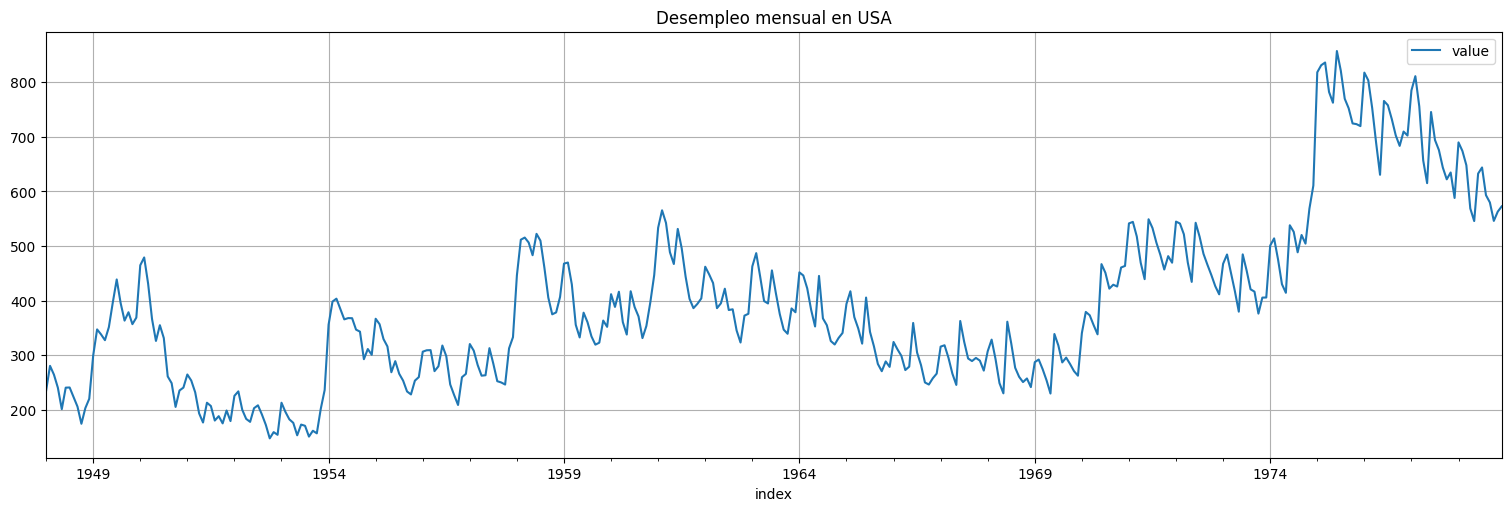

In [48]:
unemp = astsa.unemp
n=unemp.size
unemp.plot()
plt.title("Desempleo mensual en USA");

Podemos intentar ajustar un local level model a ver si sigue una tendencia central razonable:

In [49]:
model = UnobservedComponents(unemp, 'local level')
#Hago el fit, pero en realidad le fijamos todos los parámetros:
fit = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.00213D+00    |proj g|=  5.32163D-03

At iterate    5    f=  5.16685D+00    |proj g|=  1.58511D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     18      1     0     0   1.758D-06   5.167D+00
  F =   5.1667808261716077     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


In [50]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                  value   No. Observations:                  372
Model:                    local level   Log Likelihood               -1922.042
Date:                Mon, 11 Nov 2024   AIC                           3848.085
Time:                        01:33:08   BIC                           3855.917
Sample:                    01-31-1948   HQIC                          3851.196
                         - 12-31-1978                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.0003    108.430   2.35e-06      1.000    -212.518     212.519
sigma2.level      1851.2441    240.608      7.694      0.000    1379.662    2322.826
===================================================================================
Ljung-Box (L1) (Q):                   0.35   Jarque-Bera (JB):               139.77
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               2.28   Skew:                             1.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

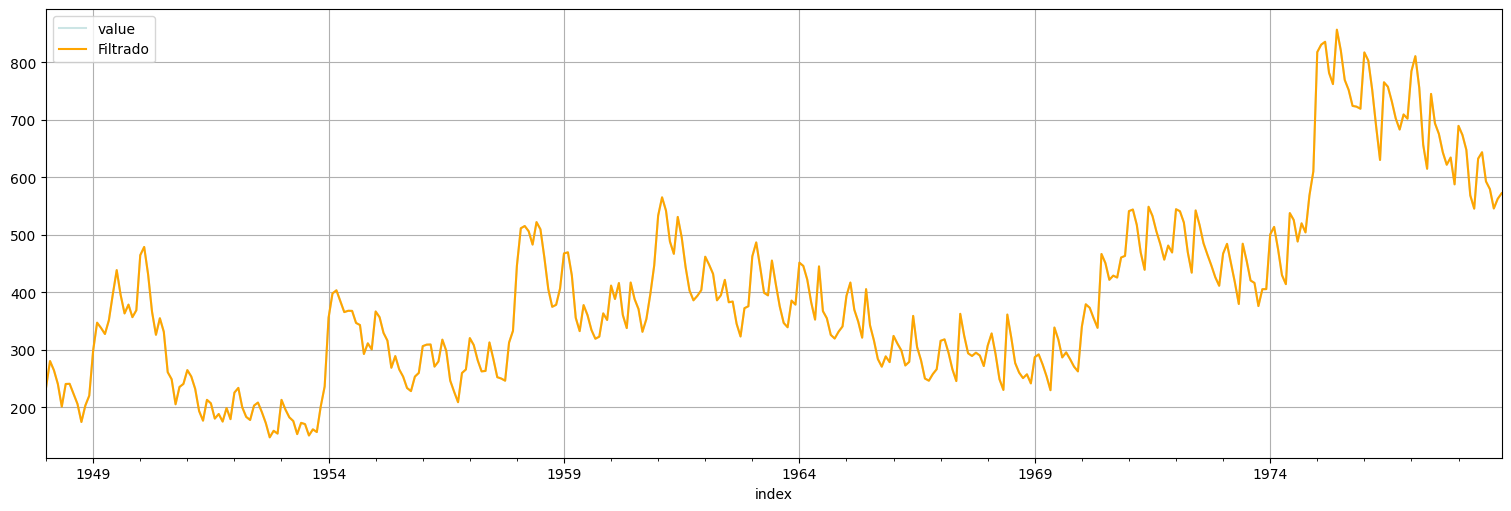

In [51]:
suavizado = fit.get_prediction(0,n-1, information_set="smoothed")
yhat = suavizado.predicted_mean
unemp.plot(alpha=0.2, color="teal", label="Observaciones");
yhat.plot(color="orange", label="Filtrado");
plt.legend();

#### Observaciones:

 * Está haciendo overfitting.
 * No está capturando las componentes cíclicas.

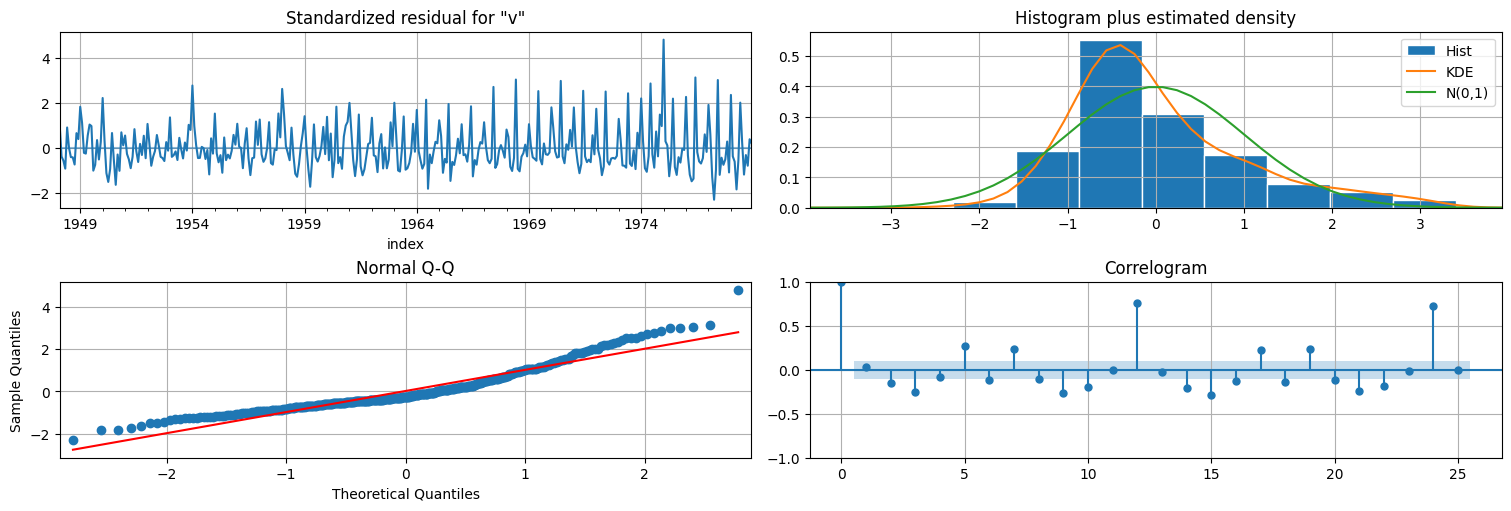

In [52]:
fit.plot_diagnostics(lags=25);

#### Modelo estructural:

Propongamos un modelo de la forma:

* La tendencia central es tipo paseo al azar:
      $$T_{t+1} = T_t + w_t$$
* La observación tiene una componente estacional $S_t$:
      $$y_t = T_t + S_t + v_t$$
* La componente estacional suma $0$ a menos de un término de error a lo largo de un período (12 muestras en este caso):
      $$S_t+S_{t-1}+\ldots+S_{t-11} = z_t$$

Con $w_t$, $v_t$ y $z_t$ ruidos blancos gaussianos de varianza a estimar.

#### Notación matricial:

El estado y la observación son:

$$x_t = \begin{pmatrix}T_t\\ S_t \\ \vdots \\ S_{t-10}\end{pmatrix} \quad \quad y_t=T_t+S_t+v_t$$

Ecuación de evolución:

$$x_{t+1} = \begin{pmatrix}T_{t+1}\\ S_{t+1} \\ \vdots \\ S_{t+1-10}\end{pmatrix} = 
\begin{pmatrix}
1 & 0 & 0 & \ldots & 0 \\
0 & -1 & -1 & \ldots & -1 \\
0 & 1 & 0 & \ldots & 0 \\
\vdots & \ddots & \ddots & \ldots & 0\\
0 & 0 & \ldots & 1 & 0
\end{pmatrix} \begin{pmatrix}T_t\\ S_t \\ \vdots \\ S_{t-10}\end{pmatrix} + \begin{pmatrix}w_t \\ z_t \\ 0 \\ \vdots \\ 0\end{pmatrix} $$

Ecuación de observación:

$$y_t = \begin{pmatrix}1 & 1 & 0 & \ldots & 0\end{pmatrix}  \begin{pmatrix}T_t\\ S_t \\ \vdots \\ S_{t-10}\end{pmatrix} + v_t$$

Es decir, corresponde a un modelo lineal general matricial con componentes:

$$\Phi = \begin{pmatrix}
1 & 0 & 0 & \ldots & 0 \\
0 & -1 & -1 & \ldots & -1 \\
0 & 1 & 0 & \ldots & 0 \\
\vdots & \ddots & \ddots & \ldots & 0\\
0 & 0 & \ldots & 1 & 0
\end{pmatrix} \quad \quad A = \begin{pmatrix}1 & 1 & 0 & \ldots & 0\end{pmatrix}$$

Por otra parte no hay entrada: $B=C=0$, y covarianzas de ruidos a estimar.

#### Implementación en Python

En la biblioteca `statsmodels` nuevamente este es uno de los modelos de la forma `UnobservedComponents`:

```python
class statsmodels.tsa.statespace.structural.UnobservedComponents(endog,
    level=False,
    trend=False,
    seasonal=None,
    freq_seasonal=None,
    cycle=False,
    autoregressive=None,
    exog=None,
    irregular=False,
    stochastic_level=False,
    stochastic_trend=False,
    stochastic_seasonal=True,
    stochastic_freq_seasonal=None,
    stochastic_cycle=False,
    damped_cycle=False,
    cycle_period_bounds=None,
    mle_regression=True,
    use_exact_diffuse=False, **kwargs)
```

En nuestro caso queremos usar `level=True` para ajustar el nivel, `stochastic_level=True`, para que indicar que el trend es un local level model y el `stochastic_seasonal = True` para lo cual tenemos que además agregar la frecuencia `seasonal=12` en este caso. `irregular=True` sirve para indicar que hay ruido de observación.

In [53]:
model = UnobservedComponents(unemp, level = True, stochastic_level=True, stochastic_seasonal=True, irregular=True, seasonal=12)
fit = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.08286D+00    |proj g|=  5.14288D-03

At iterate    5    f=  4.65891D+00    |proj g|=  4.71915D-02

At iterate   10    f=  4.40463D+00    |proj g|=  2.87472D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     32      1     0     0   5.327D-06   4.405D+00
  F =   4.4045924092547271     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


In [54]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Unobserved Components Results                            
=====================================================================================
Dep. Variable:                         value   No. Observations:                  372
Model:                           local level   Log Likelihood               -1638.508
                   + stochastic seasonal(12)   AIC                           3283.017
Date:                       Mon, 11 Nov 2024   BIC                           3294.675
Time:                               01:33:14   HQIC                          3287.652
Sample:                           01-31-1948                                         
                                - 12-31-1978                                         
Covariance Type:                         opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  6.796e-09     26.002   2.61e-10      1.000     -50.963      50.963
sigma2.level       405.0399     34.914     11.601      0.000     336.609     473.471
sigma2.seasonal      4.7733      1.894      2.521      0.012       1.062       8.484
===================================================================================
Ljung-Box (L1) (Q):                  23.36   Jarque-Bera (JB):               212.94
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                             0.81
Prob(H) (two-sided):                  0.54   Kurtosis:                         6.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

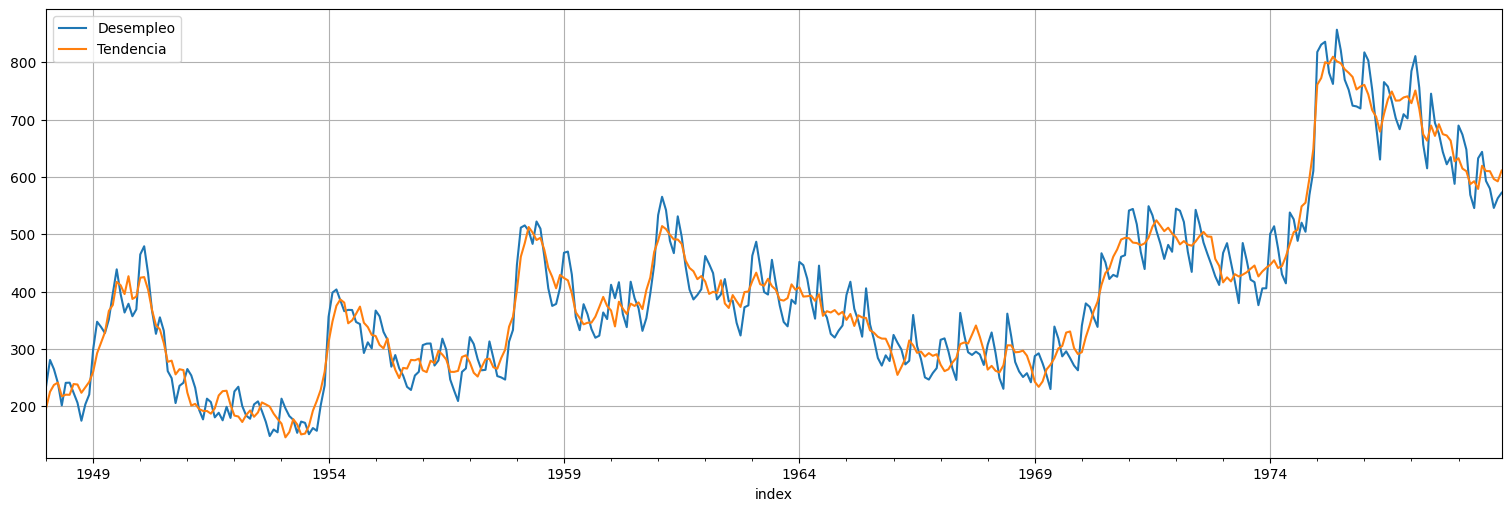

In [55]:
suavizado = fit.get_prediction(0,n-1, information_set="smoothed")
T = fit.states.smoothed["level"]
S = fit.states.smoothed["seasonal"]

unemp.plot()
T.plot();
plt.legend(["Desempleo","Tendencia"]);

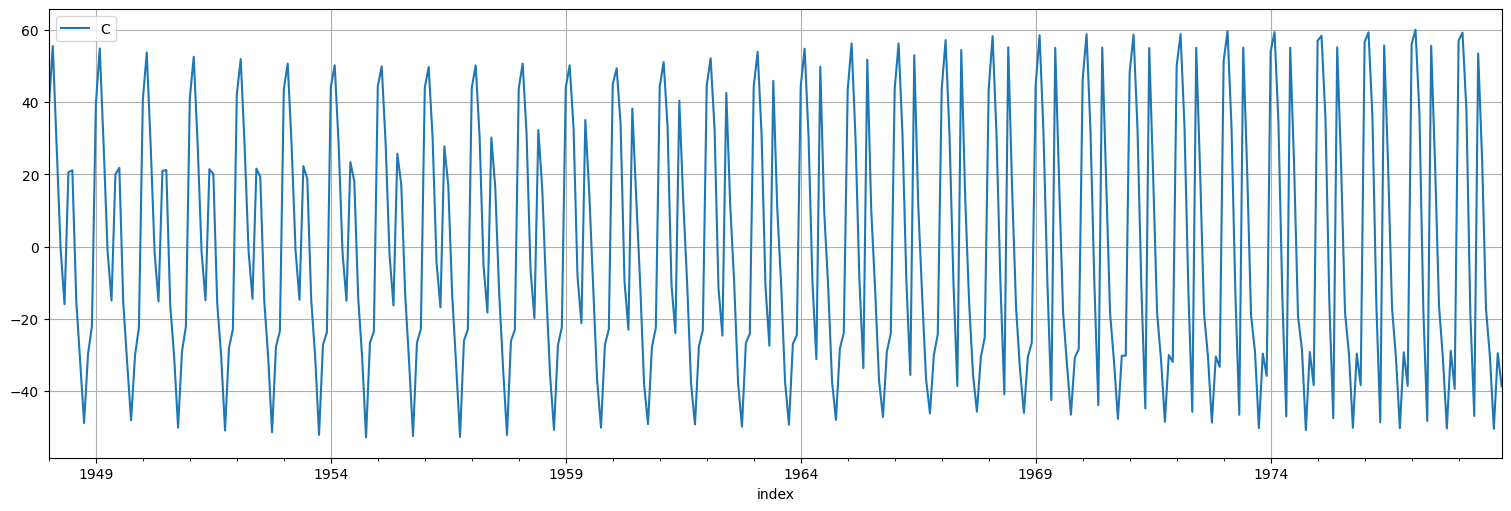

In [56]:
S.plot()
plt.legend("Componente estacional");

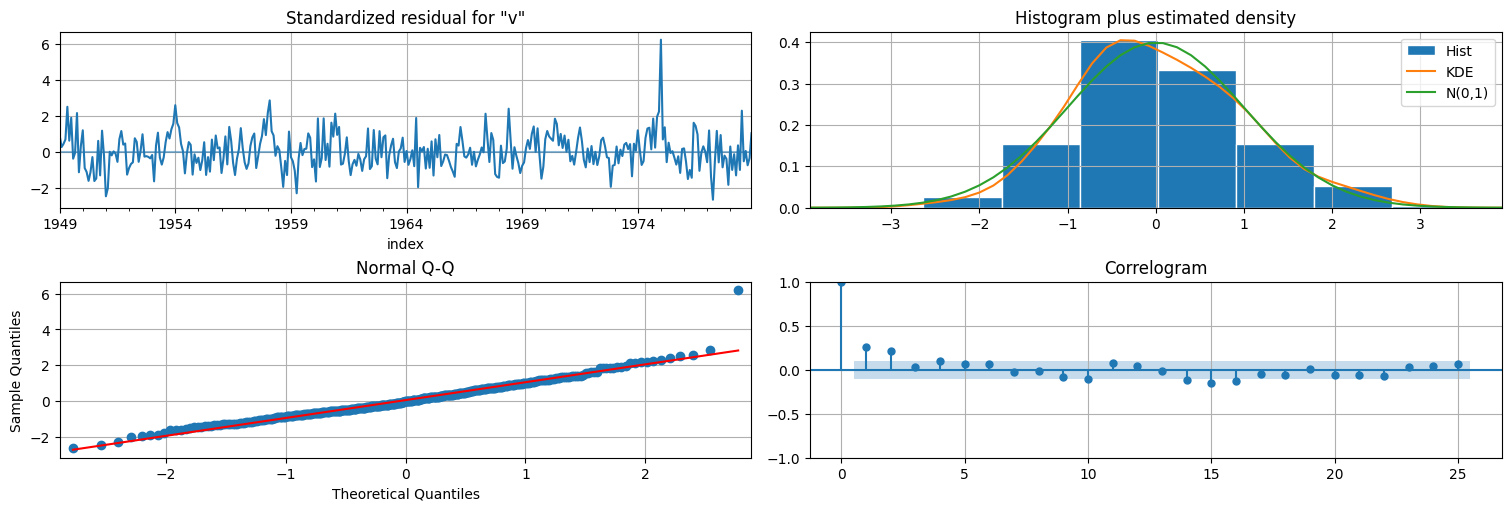

In [57]:
fit.plot_diagnostics(lags=25);

### Otros ejemplos:

* Stochastic volatility.
* Tracking de vehiculos por GPS.
* Larga lista de etc.

Los modelos en espacio de estados son una "navaja suiza". A través de sus implementaciones como `UnobservedComponents` o `SARIMAX` podemos ajustar un montón de series. En particular `SARIMAX` es la base con que se ajustan todos los modelos ARIMA que ya estudiamos.

## Ejercicios

### Modelo de espacio de estados para la serie Johnson & Johnson

Considere la serie $\log($ `jj` $)$ ya analizada en el curso. Utilizando el ejemplo anterior, proponga un modelo de tipo `UnobservedComponents` con frecuencia $4$ y componentes cíclicas estocásticas.

1. Pruebe primero incorporar tendencia determinística al modelo.
2. Pruebe luego agregar la tendencia como estocástica. ¿Esto mejora el modelo?
3. Pruebe mejorar el modelo de la parte 1. dandole una componente autorregresiva de orden $1$ (`autorregressive=1`).

Evalúe los diferentes ajustes.

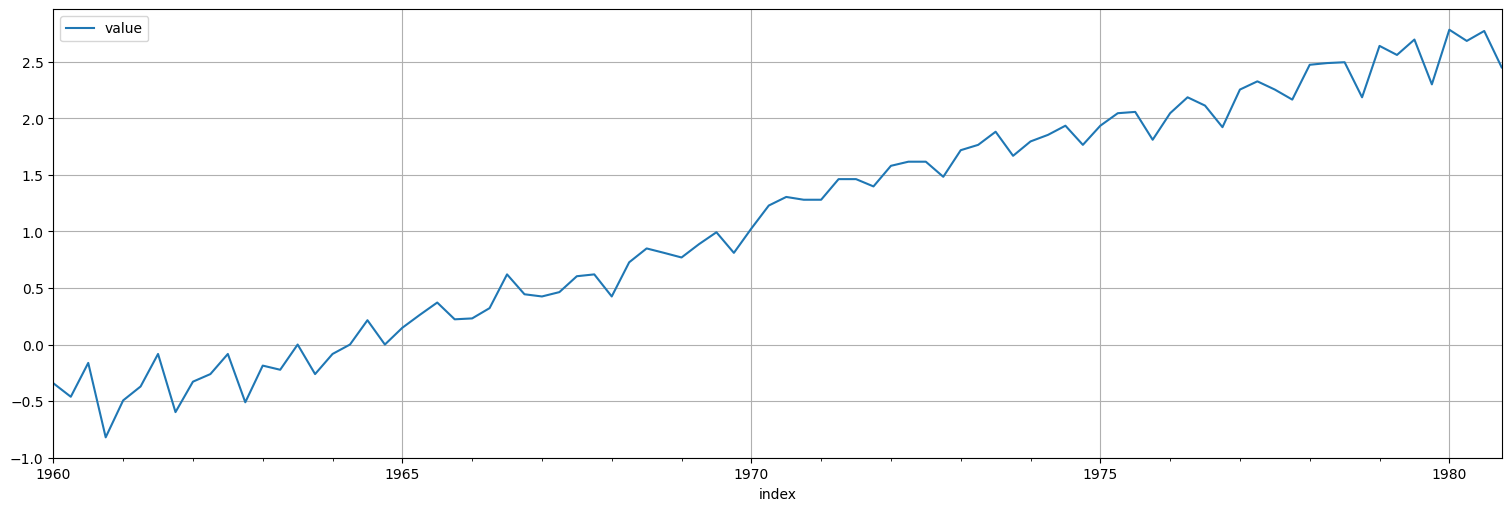

In [58]:
ljj = np.log(astsa.jj)
ljj.plot();